In [1]:
import os 
from scipy.interpolate import interp1d
sims = os.listdir('./')
sims = [i for i in sims if 'x' in i]
sims = [i for i in sims if '.txt' not in i]
sims = [i for i in sims if '.pkl' not in i]
simsnames = [i.split('_')[0][1:] for i in sims]



In [2]:
from HeaderP import *
import pynbody as pb
import pynbody.filt as filt
import os, pickle, glob
from itertools import combinations_with_replacement

In [3]:
def readsimdata(simNo,Rcut,Rcut_thread,zcut_thread,disk=True):
    if disk:
        data=pd.read_pickle('./g'+simNo+'_z_0_decomp.pkl')
    else:
        data=pd.read_pickle('./g'+simNo+'_z_0_decomp.pkl')
    data['R']=np.sqrt((data['x'])**2+data['y']**2)
    
    if Rcut:
        data=data.loc[data['Rbir']<Rcut_thread].reset_index(drop=True)
        data=data.loc[abs(data['zbir'])<zcut_thread].reset_index(drop=True)
    data['dR']=data['R']-data['Rbir']
    data['dz']=abs(data['z'])-abs(data['zbir'])
    if disk:
        data = data.loc[(data['decomp']==1)|(data['decomp']==4)].reset_index()
    return data

def normalize_data(data):
    return (data-np.mean(data))/np.std(data)

def train(y, X):
    """
    
    Args:
        y (array): An Nstar array of rotation periods.
        X (array): An Nstar x NX array of features.
        
    Returns:
        weights (array): The array of weights of length NX + 1.
        
    """
    A = np.concatenate((np.ones((len(X), 1)), X), axis=1)  # Shape: Nstars x Nfeatures (incl crossterms)
    AT = A.T
    ATA = np.dot(AT, A)
    
    weights = np.linalg.solve(ATA, np.dot(AT, y))
    return weights

In [4]:
def calcRbir_cv(data, fold=5, rescale=True):
    fold = int(fold)
    if rescale:
        args = normalize_data(data['feh']), normalize_data(data['age']), normalize_data(data['Rg'])
    else:
        args = data['feh'], data['age'], data['Rg']
    args_name = '[Fe/H]', 'τ', '$R_g$'
    
    X = list(args)
    X_names = list(args_name)
    
    if rescale:
        for a, b in combinations_with_replacement(args, 2):
            X.append(normalize_data(a * b))
    else:
        for a, b in combinations_with_replacement(args, 2):
            X.append(a * b)

    
    for a, b in combinations_with_replacement(args_name, 2):
        X_names.append(str(a + '*' + b))
        
    X = np.array(X).T


    # Define the number of training and validating stars.
    Ntest = int(1./float(fold)*np.shape(X)[0])
    y = data['Rbir'].values
    yave = np.mean(y)
    ystd = np.std(y)
    y = (y-yave)/ystd
    ypred = np.zeros(len(y))
    
    shuffle_inds = np.arange(len(y))
    np.random.shuffle(shuffle_inds)
        
    weights = np.zeros((len(X_names)+1, fold))
        
    for i in range(fold):
        if i == fold-1:
            startind = int(-Ntest)
            endind = int(len(shuffle_inds)-1)
        else:
            startind = int(i*Ntest)
            endind = int(Ntest*(i+1))
            
        train_inds = np.append(shuffle_inds[:startind],shuffle_inds[endind:])
        test_inds = shuffle_inds[startind:endind]
        y_train, X_train = y[train_inds], X[train_inds, :]
        y_test, X_test = y[test_inds], X[test_inds, :]

        weights[:, i] = train(y_train, X_train)

        A = np.concatenate((np.ones((len(X_test), 1)), X_test), axis=1)
        #print(np.shape(weights[:, i]))
        y_predict = np.dot(weights[:, i].T, A.T)
        ypred[test_inds] = y_predict

    return np.append(['$θ_C$'],X_names), [np.mean(weights[i,:]) for i in range(len(X_names)+1)], [np.std(weights[i,:]) for i in range(len(X_names)+1)], y, ypred

def calcRstd(data, Rbirbin=np.linspace(0,10,20), norm=True):
    Rbirs = np.zeros(len(Rbirbin)-1)
    Rstds = np.zeros(len(Rbirbin)-1)
    
    if norm:
        data['Rbir_norm'] = normalize_data(data['Rbir'])
        data['R_norm'] = normalize_data(data['R'])
        
    for i in range(len(Rbirbin)-1):
        
        if norm:
            data_loc = data.loc[(data['Rbir_norm']>Rbirbin[i])&(data['Rbir_norm']<Rbirbin[i+1])].reset_index(drop=True)
            Rstds[i] = np.std(data_loc['R_norm']-data_loc['Rbir_norm'])
        else:
            data_loc = data.loc[(data['Rbir']>Rbirbin[i])&(data['Rbir']<Rbirbin[i+1])].reset_index(drop=True)
            Rstds[i] = np.std(data_loc['R']-data_loc['Rbir'])
            
        Rbirs[i] = (Rbirbin[i]+Rbirbin[i+1])/2
    return Rbirs, Rstds

def calcRstd_inf(infRbir, trueRbir, Rbirbin=np.linspace(0,10,20)):
    Rbirs = np.zeros(len(Rbirbin)-1)
    Rstds = np.zeros(len(Rbirbin)-1)
    for i in range(len(Rbirbin)-1):
        m = (trueRbir>Rbirbin[i])&(trueRbir<Rbirbin[i+1])
        Rstds[i] = np.std(trueRbir[m]-infRbir[m])
        Rbirs[i] = (Rbirbin[i]+Rbirbin[i+1])/2
    return Rbirs, Rstds

def predNew(weights, data, rescale=True):
    weights = np.array(weights)
    data = data.dropna(subset=['feh','age','Rg'])
    if rescale:
        args = normalize_data(data['feh']), normalize_data(data['age']), normalize_data(data['Rg'])
    else:
        args = data['feh'], data['age'], data['Rg']
        
    X = list(args)
    if rescale:
        for a, b in combinations_with_replacement(args, 2):
            X.append(normalize_data(a * b))
    else:
        for a, b in combinations_with_replacement(args, 2):
            X.append(a * b)
    X = np.array(X).T
    y = normalize_data(data['Rbir'].values)
    A = np.concatenate((np.ones((len(X), 1)), X), axis=1)
    y_predict = np.dot(weights.T, A.T)
    return y, y_predict


Use 6.96e11

In [5]:
i=0
simNo=simsnames[i]
Rcut=True
Rcut_thread=15
zcut_thread=5

print('Reading in simulation...')
data = readsimdata(simNo,Rcut,Rcut_thread,zcut_thread)
print('Finished reading in simulation...')

print('Calculating weights...')
allnames, weights, weights_err, y, ypred = calcRbir_cv(data)
print('Finished calculating weights...')


Reading in simulation...
Finished reading in simulation...
Calculating weights...
Finished calculating weights...


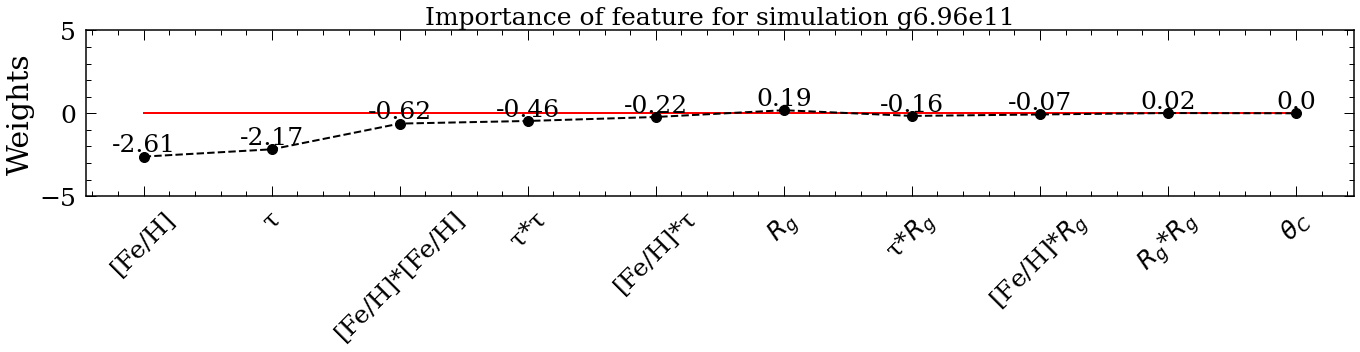

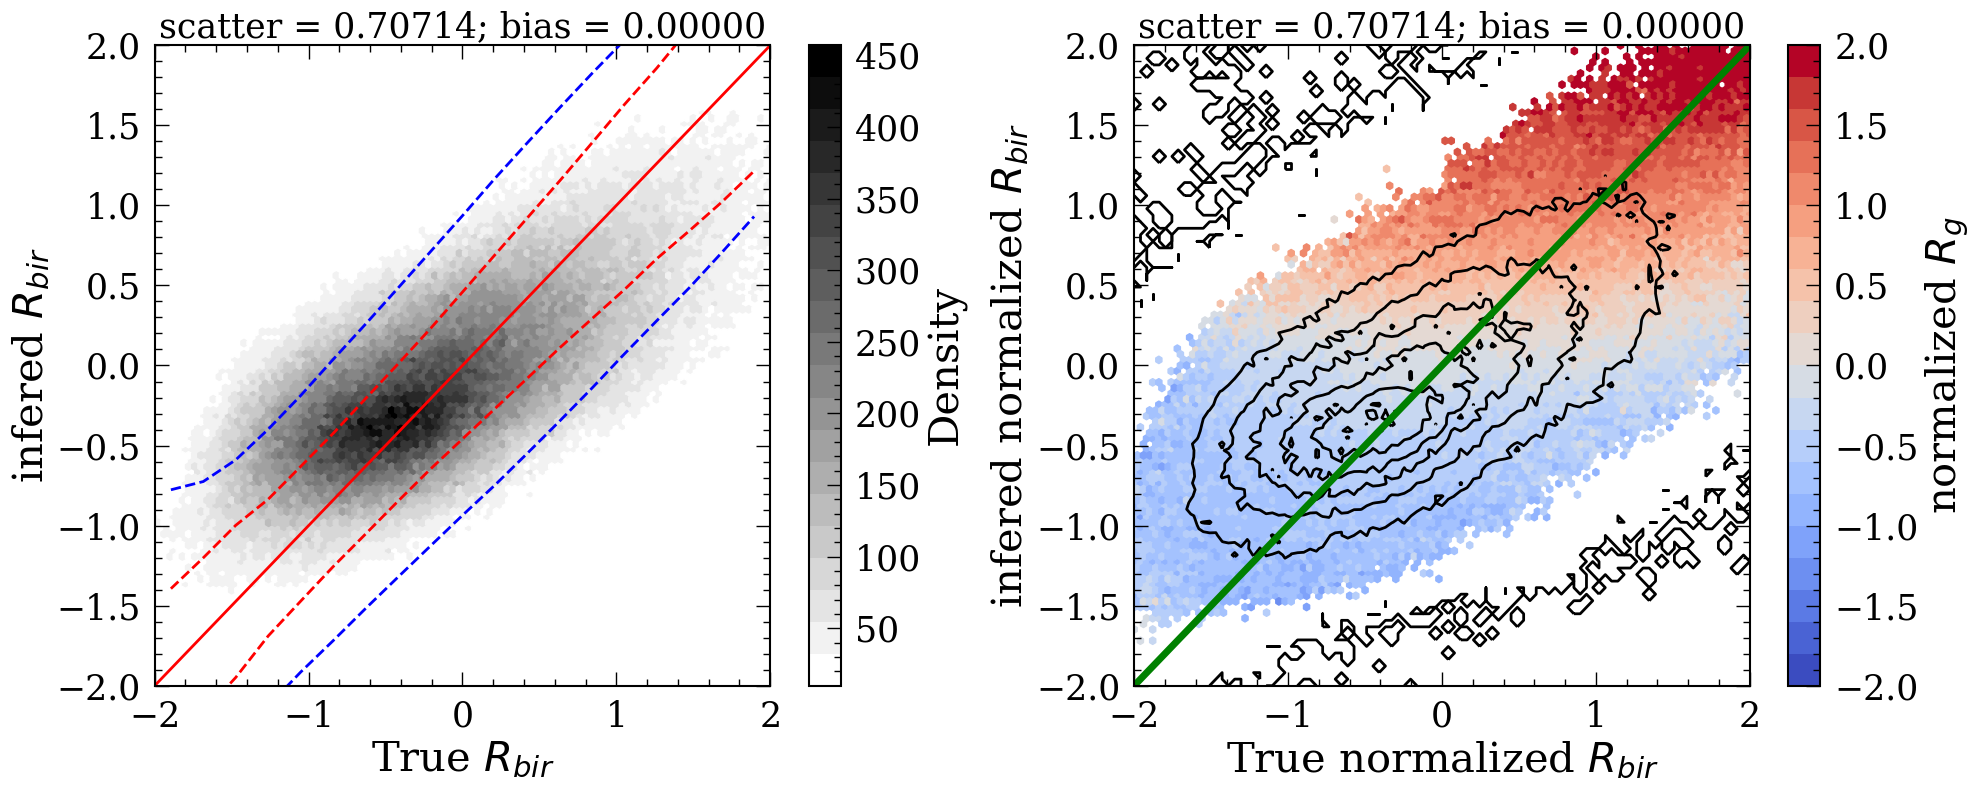

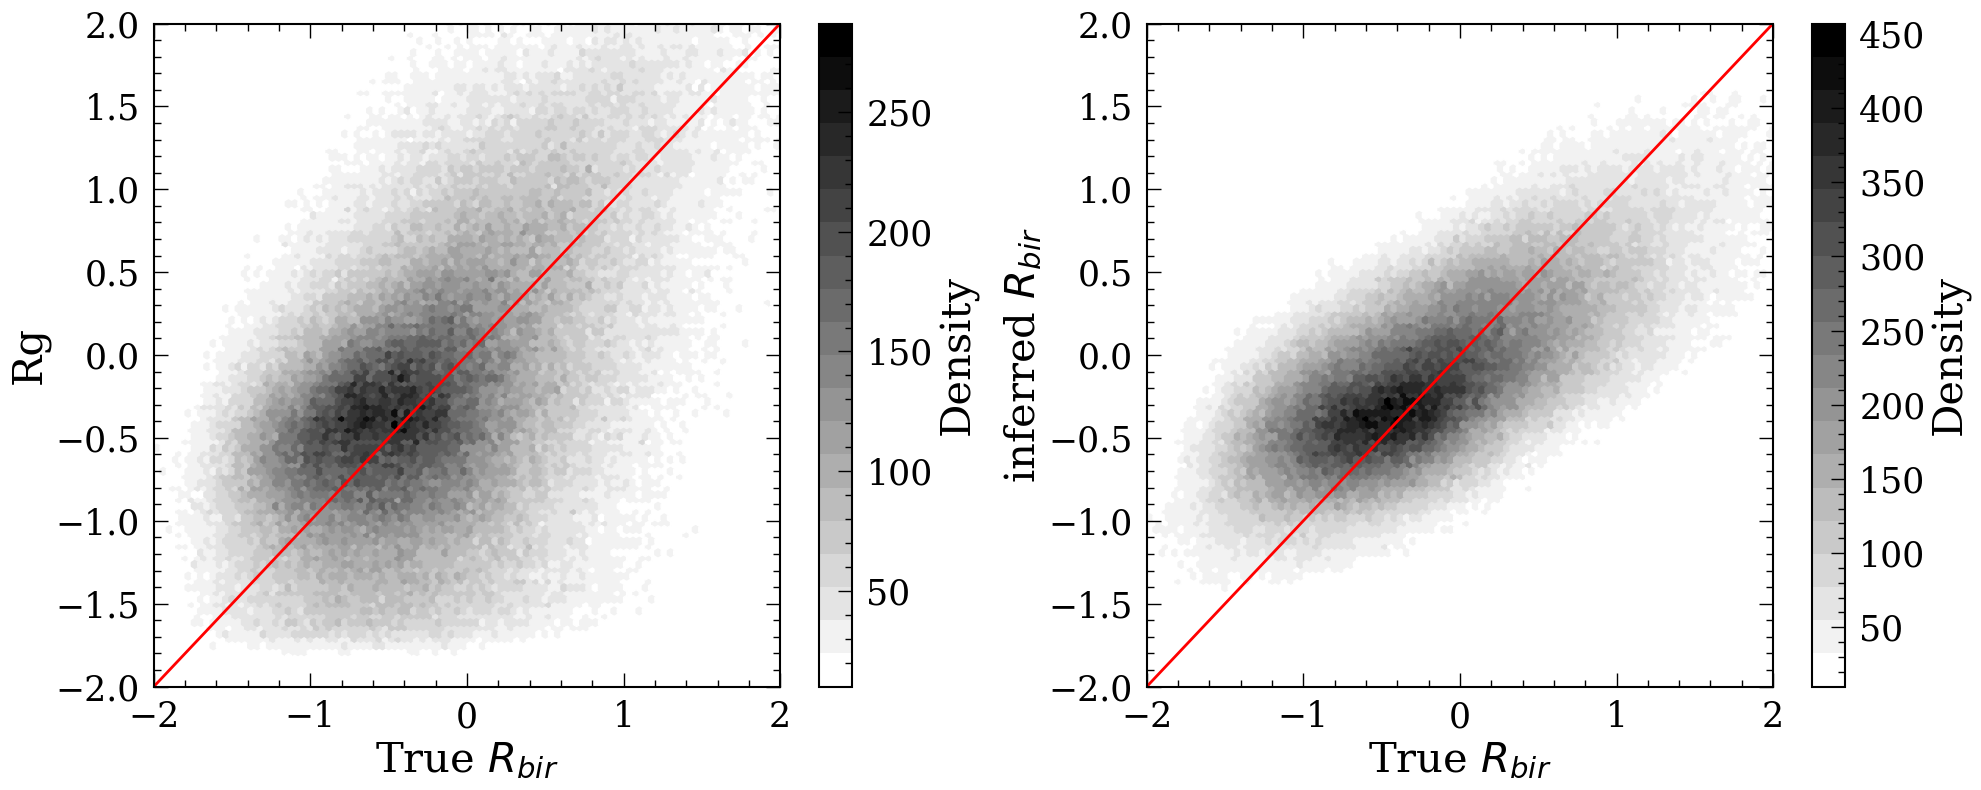

In [6]:
plt.figure(figsize=(19,5))
absweights, weights_imp, weights_imp_err, allnames_imp = zip(*sorted(zip(abs(np.array(weights)), weights, weights_err, allnames)))
weights_imp, allnames_imp = weights_imp[::-1], allnames_imp[::-1]
plt.errorbar(range(len(allnames_imp)), np.array(weights_imp), yerr=np.array(weights_imp_err), fmt='k--o', markersize=10)
plt.plot(range(len(allnames_imp)),np.zeros(len(allnames_imp)),'r-')
plt.xticks(range(len(allnames_imp)), allnames_imp, rotation=45)
#plt.xlabel('Features')
plt.ylabel('Weights')
plt.ylim([-5,5])
plt.title('Importance of feature for simulation g%s'%simsnames[i], fontsize=25)

for j, txt in enumerate(weights_imp):
    txt = np.round(txt,2)
    plt.annotate(txt, (j, weights_imp[j]),size=25,horizontalalignment='center', verticalalignment='bottom')
plt.tight_layout()
plt.savefig(simsnames[i]+'_importance.png')

xs = np.linspace(-2, 2, 100)


plt.figure(figsize=(20,8), dpi=100)
plt.subplot(1,2,1)
scatter = np.std(y-ypred)
bias  = np.mean(y-ypred)
cmap = plt.cm.get_cmap('binary',20)
plt.hexbin(y, ypred, extent=(-2,2,-2,2),gridsize=100, mincnt=10, cmap=cmap)

Rbirs, Rstds = calcRstd(data, Rbirbin=np.linspace(-2,2,20))
Rbirs_inf, Rstds_inf = calcRstd_inf(ypred, y, Rbirbin=np.linspace(-2,2,20))

plt.plot(Rbirs, Rbirs+Rstds, 'b--', label = '$σ_{rm}$')
plt.plot(Rbirs, Rbirs-Rstds, 'b--')
plt.plot(Rbirs_inf, Rbirs_inf-Rstds_inf, 'r--', label = '$σ_{inf}$')
plt.plot(Rbirs_inf, Rbirs_inf+Rstds_inf, 'r--')
plt.plot(xs, xs, "r-")
plt.xlim(-2, 2)
plt.ylim(-2, 2)
plt.xlabel("True $R_{bir}$")
plt.ylabel("infered $R_{bir}$")
plt.title('scatter = %.5f; bias = %.5f'%(scatter, bias),fontsize=25)
cb = plt.colorbar()
cb.set_label('Density')

plt.subplot(1,2,2)
cmap1 = plt.cm.get_cmap('coolwarm',20)
scatter = np.std(y-ypred)
bias  = np.mean(y-ypred)
plt.hexbin(y, ypred, C = normalize_data(data['Rg'].values), extent = (-2,2,-2,2), gridsize = 100, 
           cmap = cmap1, vmin = -2, vmax = 2, mincnt=10)
plt.plot(xs, xs, "g-", linewidth=5)
plt.xlim(-2, 2)
plt.ylim(-2, 2)
plt.xlabel("True normalized $R_{bir}$")
plt.ylabel("infered normalized $R_{bir}$")
plt.title('scatter = %.5f; bias = %.5f'%(scatter, bias),fontsize=25)
cb = plt.colorbar()
cb.set_label('normalized $R_g$')
from matplotlib.colors import LogNorm
counts,xbins,ybins=np.histogram2d(y, ypred, bins = (np.linspace(-2,2,100),np.linspace(-2,2,100)))
plt.contour(counts.transpose(),extent=[xbins.min(),xbins.max(),
    ybins.min(),ybins.max()],linewidths=2,colors='black',
    linestyles='solid')
plt.tight_layout()

plt.figure(figsize=(20,8), dpi=100)
plt.subplot(1,2,1)
plt.hexbin(normalize_data(data['Rbir']), normalize_data(data['Rg']), 
           extent=(-2,2,-2,2),gridsize=100, mincnt=10, cmap=cmap)

plt.plot(xs, xs, "r-")
plt.xlim(-2, 2)
plt.ylim(-2, 2)
plt.xlabel("True $R_{bir}$")
plt.ylabel("Rg")
#plt.title('scatter = %.5f; bias = %.5f'%(scatter, bias),fontsize=25)
cb = plt.colorbar()
cb.set_label('Density')

plt.subplot(1,2,2)
plt.hexbin(y, ypred, 
           extent=(-2,2,-2,2),gridsize=100, mincnt=10, cmap=cmap)

plt.plot(xs, xs, "r-")
plt.xlim(-2, 2)
plt.ylim(-2, 2)
plt.xlabel("True $R_{bir}$")
plt.ylabel("inferred $R_{bir}$")
#plt.title('scatter = %.5f; bias = %.5f'%(scatter, bias),fontsize=25)
cb = plt.colorbar()
cb.set_label('Density')

plt.tight_layout()

  0%|          | 0/6 [00:00<?, ?it/s]

8.26e11
Reading in simulation...
Finished reading in simulation...


/data/shared_data/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:261: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/data/shared_data/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:221: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/data/shared_data/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:253: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
 33%|███▎      | 2/6 [00:04<00:09,  2.35s/it]

7.08e11
Reading in simulation...
Finished reading in simulation...


 50%|█████     | 3/6 [00:09<00:10,  3.53s/it]

2.79e12
Reading in simulation...
Finished reading in simulation...


/data/shared_data/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:261: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/data/shared_data/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:221: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/data/shared_data/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:253: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
 83%|████████▎ | 5/6 [00:19<00:04,  4.15s/it]

7.55e11
Reading in simulation...
Finished reading in simulation...


/data/shared_data/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:261: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/data/shared_data/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:221: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/data/shared_data/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:253: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
100%|██████████| 6/6 [00:24<00:00,  4.11s/it]


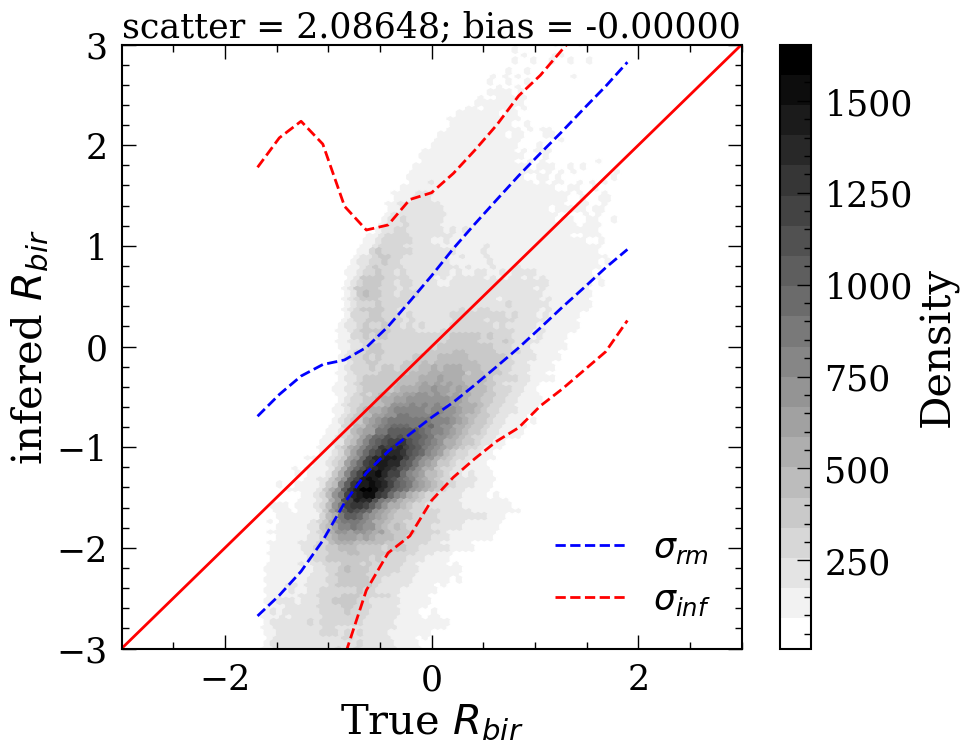

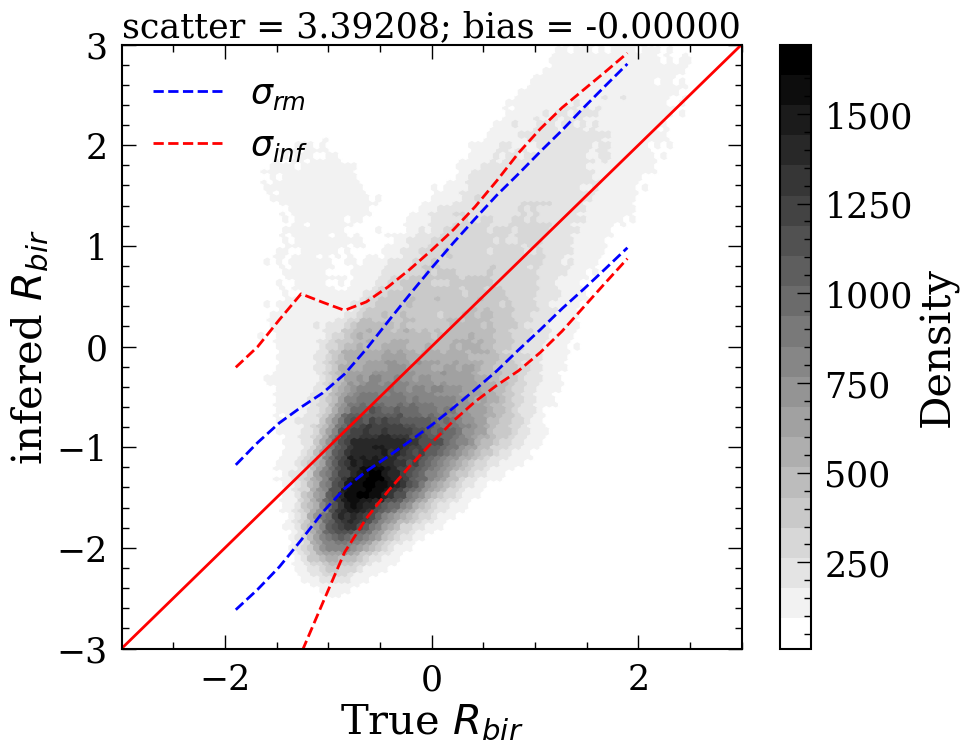

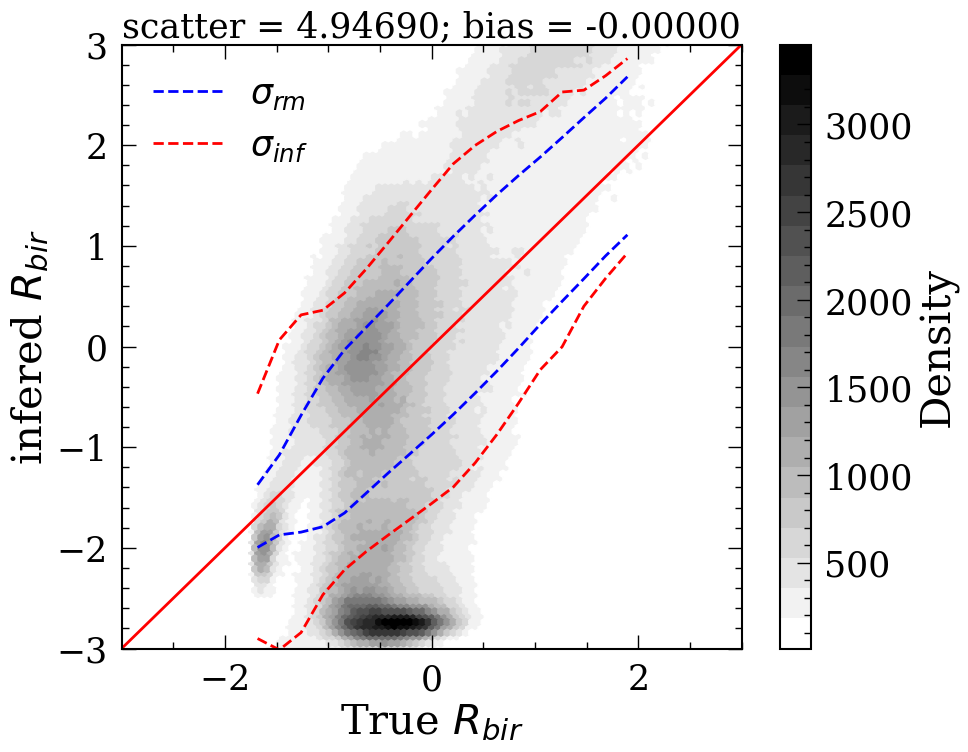

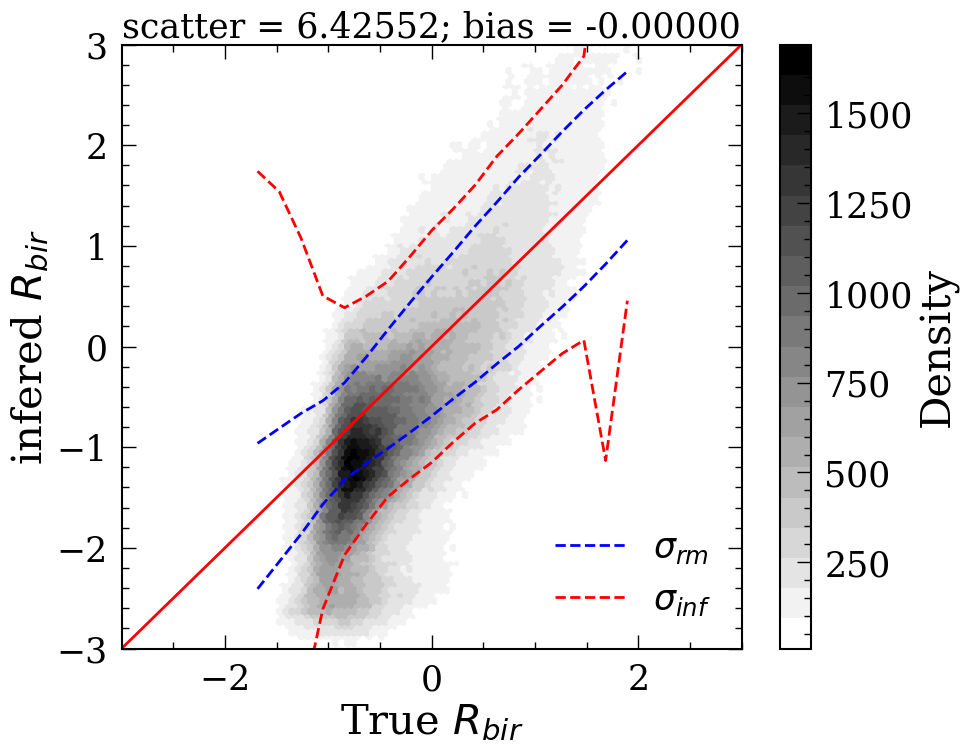

In [7]:
cmap = plt.cm.get_cmap('binary',20)
scatter, bias, diffinf = 0, 0, 0
for i in trange(len(simsnames)):
    if simsnames[i]=='1.12e12' or simsnames[i]==simNo:
        continue
    else:
        print(simsnames[i])
        
    simNo=simsnames[i]
    Rcut=True
    Rcut_thread=15
    zcut_thread=5
    
    print('Reading in simulation...')
    data = readsimdata(simNo,Rcut,Rcut_thread,zcut_thread)
    print('Finished reading in simulation...')

    y, ypred = predNew(weights, data)
    
    plt.figure(figsize=(10,8), dpi=100)
    scatter = np.std(y-ypred)+scatter
    bias  = np.mean(y-ypred)+bias
    
    plt.hexbin(y, ypred, extent=(-3,3,-3,3),gridsize=100, mincnt=10, cmap=cmap)
    Rbirs, Rstds = calcRstd(data, Rbirbin=np.linspace(-2,2,20))
    Rbirs_inf, Rstds_inf = calcRstd_inf(ypred, y, Rbirbin=np.linspace(-2,2,20))
    plt.plot(Rbirs, Rbirs+Rstds, 'b--', label = '$σ_{rm}$')
    plt.plot(Rbirs, Rbirs-Rstds, 'b--')
    plt.plot(Rbirs_inf, Rbirs_inf-Rstds_inf, 'r--', label = '$σ_{inf}$')
    plt.plot(Rbirs_inf, Rbirs_inf+Rstds_inf, 'r--')
    diffinf = diffinf+(Rstds-Rstds_inf)
    plt.plot([-3, 3], [-3, 3], "r-")
    plt.xlim(-3,3)
    plt.ylim(-3,3)
    plt.xlabel("True $R_{bir}$")
    plt.ylabel("infered $R_{bir}$")
    plt.title('scatter = %.5f; bias = %.5f'%(scatter, bias),fontsize=25)
    plt.legend()
    cb = plt.colorbar()
    cb.set_label('Density')
    plt.savefig(simsnames[i]+'_Rbirth_predW_model_disk_Rg'+simsnames[0]+'.png')
scatter = scatter/4
bias = bias/4
diffinf = np.mean(pd.Series(diffinf).dropna())/4

out696 = pd.DataFrame(np.array((np.append(allnames,['scatter','bias','scatter_pred',
                                                    'bias_pred','mean $σ_{rm}-σ_{inf}$']),
                               np.append(weights,[np.std(y-ypred),np.mean(y-ypred),scatter,bias,diffinf]), 
                               np.append(weights_err,[0, 0, 0, 0, 0]))).T,
                      columns=['names','w696','w_err696'])


Use 8.26e11

In [8]:
i=1
simNo=simsnames[i]
Rcut=True
Rcut_thread=15
zcut_thread=5

print('Reading in simulation...')
data = readsimdata(simNo,Rcut,Rcut_thread,zcut_thread)
print('Finished reading in simulation...')

print('Calculating weights...')
allnames, weights, weights_err, y, ypred = calcRbir_cv(data)
print('Finished calculating weights...')


Reading in simulation...
Finished reading in simulation...
Calculating weights...
Finished calculating weights...


/data/shared_data/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:261: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/data/shared_data/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:221: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/data/shared_data/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:253: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


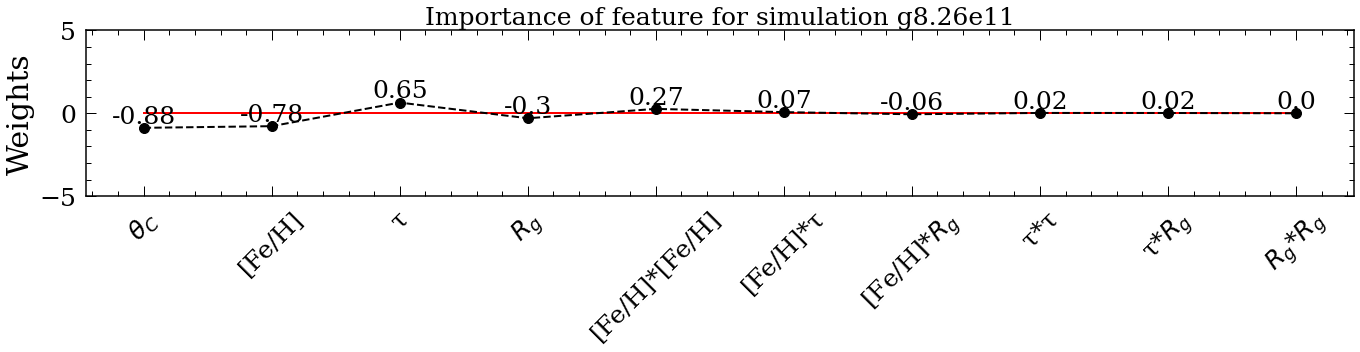

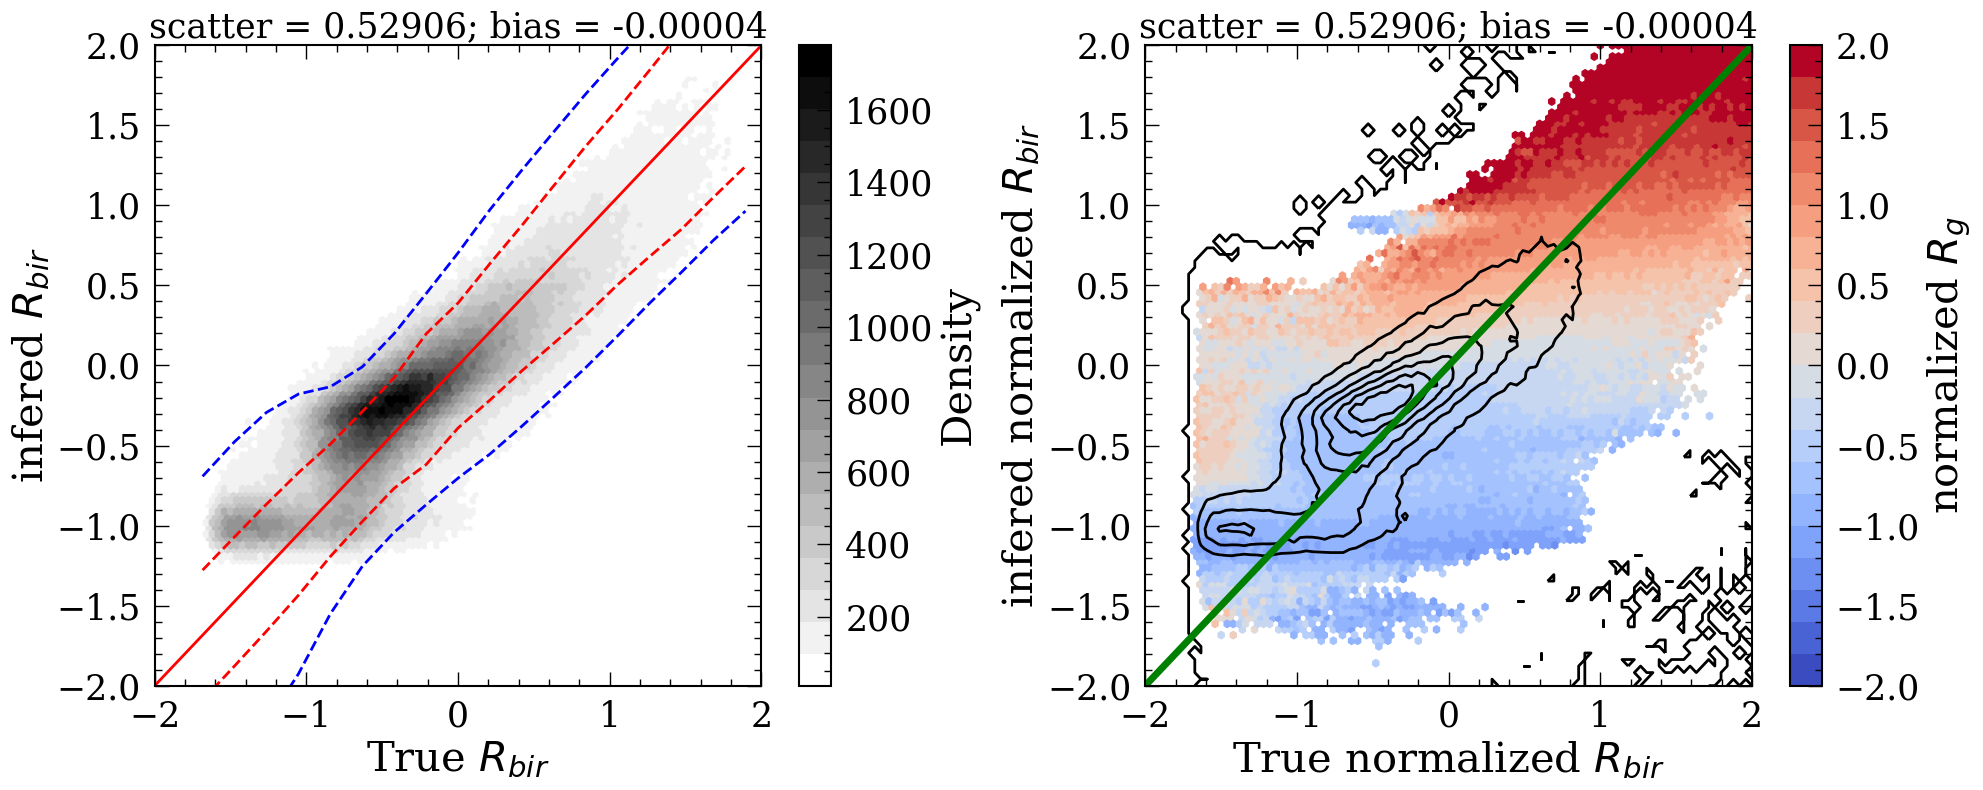

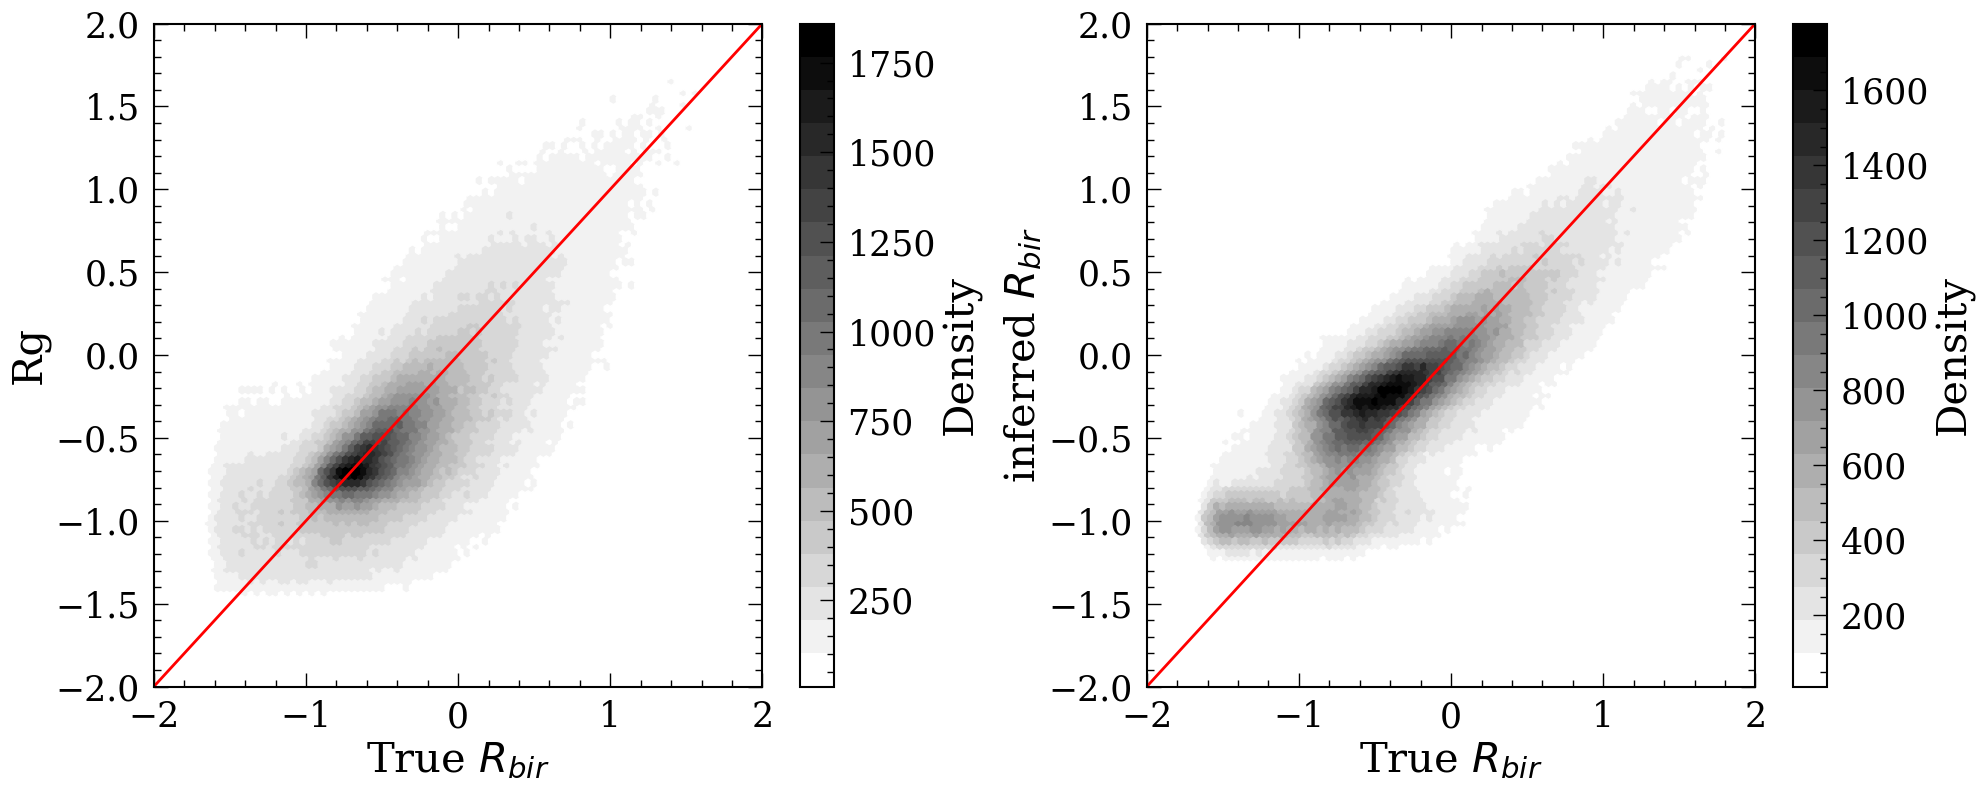

In [9]:
plt.figure(figsize=(19,5))
absweights, weights_imp, weights_imp_err, allnames_imp = zip(*sorted(zip(abs(np.array(weights)), weights, weights_err, allnames)))
weights_imp, allnames_imp = weights_imp[::-1], allnames_imp[::-1]
plt.errorbar(range(len(allnames_imp)), np.array(weights_imp), yerr=np.array(weights_imp_err), fmt='k--o', markersize=10)
plt.plot(range(len(allnames_imp)),np.zeros(len(allnames_imp)),'r-')
plt.xticks(range(len(allnames_imp)), allnames, rotation=45)
#plt.xlabel('Features')
plt.ylabel('Weights')
plt.ylim([-5,5])
plt.title('Importance of feature for simulation g%s'%simsnames[i], fontsize=25)

for j, txt in enumerate(weights_imp):
    txt = np.round(txt,2)
    plt.annotate(txt, (j, weights_imp[j]),size=25,horizontalalignment='center', verticalalignment='bottom')
plt.tight_layout()
plt.savefig(simsnames[i]+'_importance.png')

xs = np.linspace(-2, 2, 100)


plt.figure(figsize=(20,8), dpi=100)
plt.subplot(1,2,1)
scatter = np.std(y-ypred)
bias  = np.mean(y-ypred)
cmap = plt.cm.get_cmap('binary',20)
plt.hexbin(y, ypred, extent=(-2,2,-2,2),gridsize=100, mincnt=10, cmap=cmap)

Rbirs, Rstds = calcRstd(data, Rbirbin=np.linspace(-2,2,20))
Rbirs_inf, Rstds_inf = calcRstd_inf(ypred, y, Rbirbin=np.linspace(-2,2,20))

plt.plot(Rbirs, Rbirs+Rstds, 'b--', label = '$σ_{rm}$')
plt.plot(Rbirs, Rbirs-Rstds, 'b--')
plt.plot(Rbirs_inf, Rbirs_inf-Rstds_inf, 'r--', label = '$σ_{inf}$')
plt.plot(Rbirs_inf, Rbirs_inf+Rstds_inf, 'r--')
plt.plot(xs, xs, "r-")
plt.xlim(-2, 2)
plt.ylim(-2, 2)
plt.xlabel("True $R_{bir}$")
plt.ylabel("infered $R_{bir}$")
plt.title('scatter = %.5f; bias = %.5f'%(scatter, bias),fontsize=25)
cb = plt.colorbar()
cb.set_label('Density')

plt.subplot(1,2,2)
cmap1 = plt.cm.get_cmap('coolwarm',20)
scatter = np.std(y-ypred)
bias  = np.mean(y-ypred)
plt.hexbin(y, ypred, C = normalize_data(data['Rg'].values), extent = (-2,2,-2,2), gridsize = 100, 
           cmap = cmap1, vmin = -2, vmax = 2, mincnt=10)
plt.plot(xs, xs, "g-", linewidth=5)
plt.xlim(-2, 2)
plt.ylim(-2, 2)
plt.xlabel("True normalized $R_{bir}$")
plt.ylabel("infered normalized $R_{bir}$")
plt.title('scatter = %.5f; bias = %.5f'%(scatter, bias),fontsize=25)
cb = plt.colorbar()
cb.set_label('normalized $R_g$')
from matplotlib.colors import LogNorm
counts,xbins,ybins=np.histogram2d(y, ypred, bins = (np.linspace(-2,2,100),np.linspace(-2,2,100)))
plt.contour(counts.transpose(),extent=[xbins.min(),xbins.max(),
    ybins.min(),ybins.max()],linewidths=2,colors='black',
    linestyles='solid')
plt.tight_layout()

plt.figure(figsize=(20,8), dpi=100)
plt.subplot(1,2,1)
plt.hexbin(normalize_data(data['Rbir']), normalize_data(data['Rg']), 
           extent=(-2,2,-2,2),gridsize=100, mincnt=10, cmap=cmap)

plt.plot(xs, xs, "r-")
plt.xlim(-2, 2)
plt.ylim(-2, 2)
plt.xlabel("True $R_{bir}$")
plt.ylabel("Rg")
#plt.title('scatter = %.5f; bias = %.5f'%(scatter, bias),fontsize=25)
cb = plt.colorbar()
cb.set_label('Density')

plt.subplot(1,2,2)
plt.hexbin(y, ypred, 
           extent=(-2,2,-2,2),gridsize=100, mincnt=10, cmap=cmap)

plt.plot(xs, xs, "r-")
plt.xlim(-2, 2)
plt.ylim(-2, 2)
plt.xlabel("True $R_{bir}$")
plt.ylabel("inferred $R_{bir}$")
#plt.title('scatter = %.5f; bias = %.5f'%(scatter, bias),fontsize=25)
cb = plt.colorbar()
cb.set_label('Density')

plt.tight_layout()

  0%|          | 0/6 [00:00<?, ?it/s]

6.96e11
Reading in simulation...
Finished reading in simulation...


 17%|█▋        | 1/6 [00:02<00:13,  2.76s/it]

8.26e11
Reading in simulation...
Finished reading in simulation...


/data/shared_data/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:261: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/data/shared_data/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:221: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/data/shared_data/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:253: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
 33%|███▎      | 2/6 [00:07<00:14,  3.74s/it]

7.08e11
Reading in simulation...
Finished reading in simulation...


 50%|█████     | 3/6 [00:12<00:12,  4.25s/it]

2.79e12
Reading in simulation...
Finished reading in simulation...


/data/shared_data/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:261: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/data/shared_data/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:221: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/data/shared_data/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:253: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
 83%|████████▎ | 5/6 [00:21<00:04,  4.51s/it]

7.55e11
Reading in simulation...
Finished reading in simulation...


/data/shared_data/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:261: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/data/shared_data/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:221: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/data/shared_data/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:253: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
100%|██████████| 6/6 [00:26<00:00,  4.48s/it]


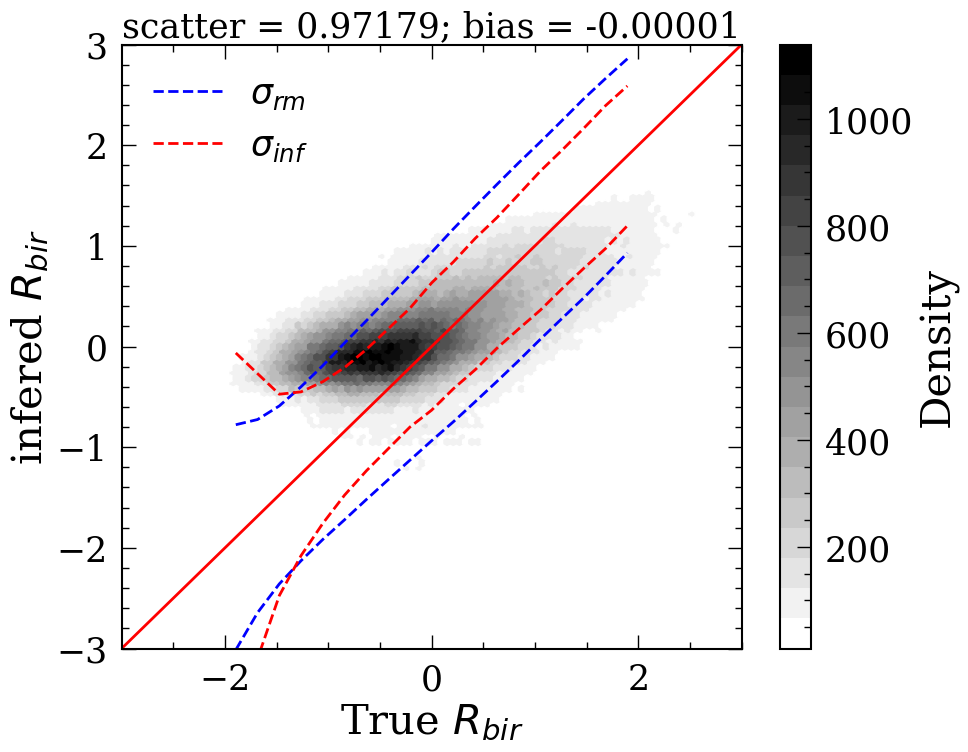

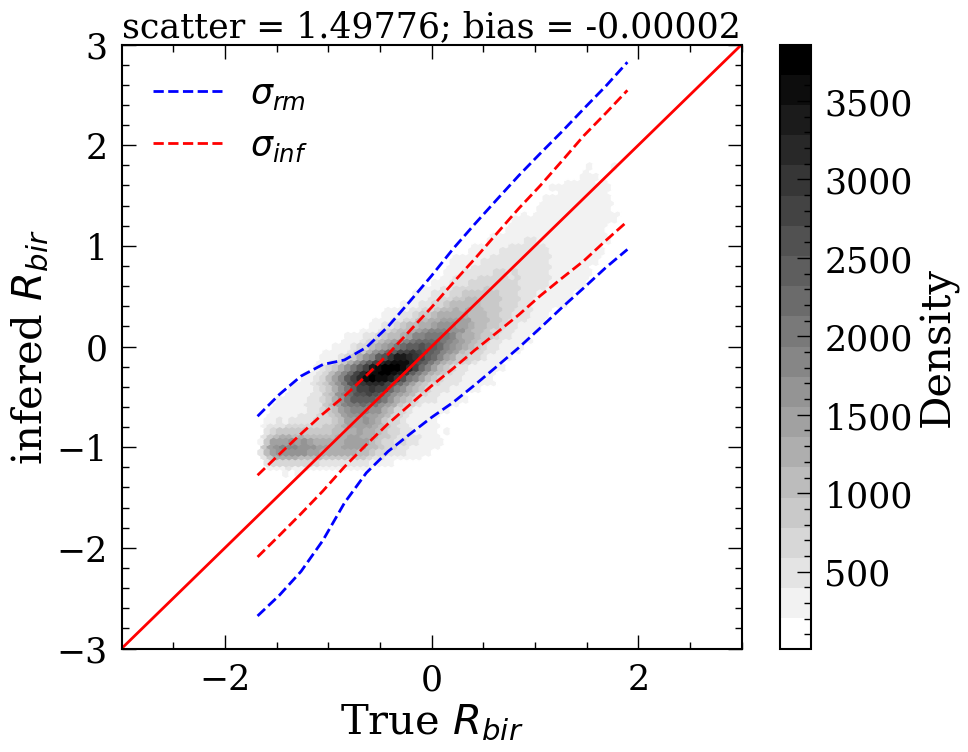

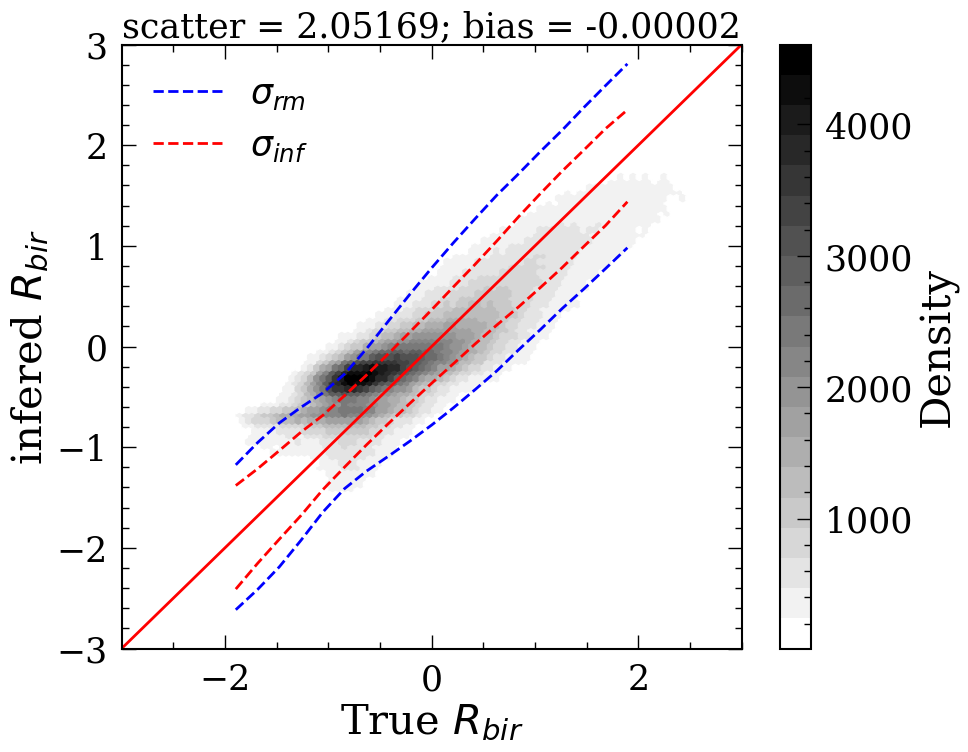

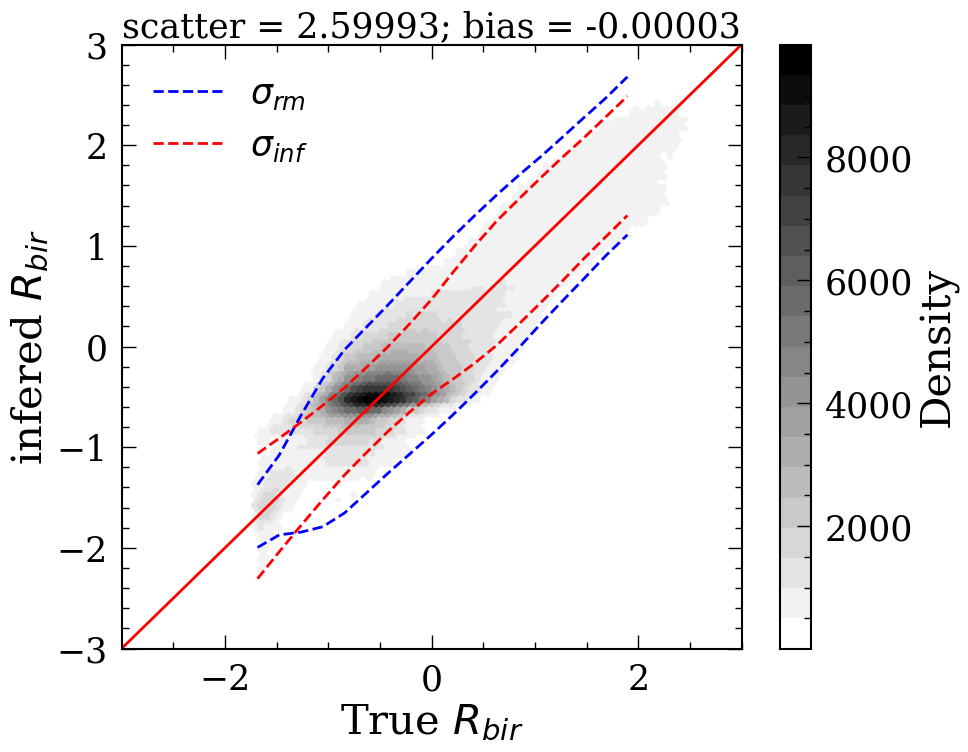

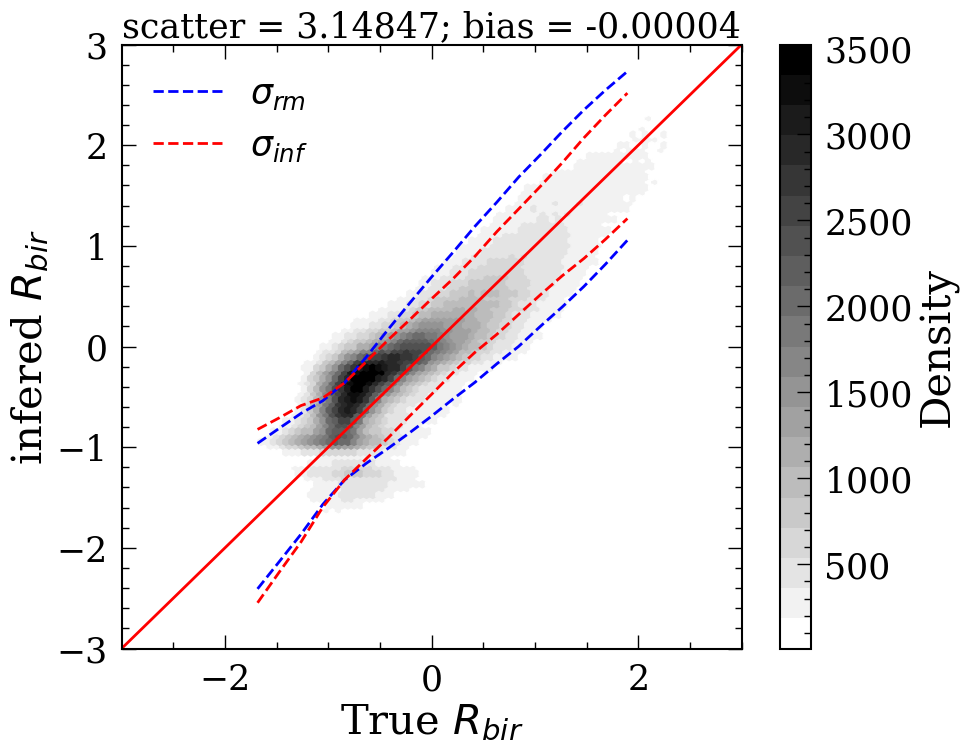

In [10]:
cmap = plt.cm.get_cmap('binary',20)
scatter, bias, diffinf = 0, 0, 0
for i in trange(len(simsnames)):
    if simsnames[i]=='1.12e12' or simsnames[i]==simNo:
        continue
    else:
        print(simsnames[i])
        
    simNo=simsnames[i]
    Rcut=True
    Rcut_thread=15
    zcut_thread=5
    
    print('Reading in simulation...')
    data = readsimdata(simNo,Rcut,Rcut_thread,zcut_thread)
    print('Finished reading in simulation...')

    y, ypred = predNew(weights, data)
    
    plt.figure(figsize=(10,8), dpi=100)
    scatter = np.std(y-ypred)+scatter
    bias  = np.mean(y-ypred)+bias
    
    plt.hexbin(y, ypred, extent=(-3,3,-3,3),gridsize=100, mincnt=10, cmap=cmap)
    Rbirs, Rstds = calcRstd(data, Rbirbin=np.linspace(-2,2,20))
    Rbirs_inf, Rstds_inf = calcRstd_inf(ypred, y, Rbirbin=np.linspace(-2,2,20))
    plt.plot(Rbirs, Rbirs+Rstds, 'b--', label = '$σ_{rm}$')
    plt.plot(Rbirs, Rbirs-Rstds, 'b--')
    plt.plot(Rbirs_inf, Rbirs_inf-Rstds_inf, 'r--', label = '$σ_{inf}$')
    plt.plot(Rbirs_inf, Rbirs_inf+Rstds_inf, 'r--')
    diffinf = diffinf+(Rstds-Rstds_inf)
    plt.plot([-3, 3], [-3, 3], "r-")
    plt.xlim(-3,3)
    plt.ylim(-3,3)
    plt.xlabel("True $R_{bir}$")
    plt.ylabel("infered $R_{bir}$")
    plt.title('scatter = %.5f; bias = %.5f'%(scatter, bias),fontsize=25)
    plt.legend()
    cb = plt.colorbar()
    cb.set_label('Density')
    plt.savefig(simsnames[i]+'_Rbirth_predW_model_disk_Rg'+simsnames[0]+'.png')
scatter = scatter/4
bias = bias/4
diffinf = np.mean(pd.Series(diffinf).dropna())/4

out826 = pd.DataFrame(np.array((np.append(allnames,['scatter','bias','scatter_pred',
                                                    'bias_pred','mean $σ_{rm}-σ_{inf}$']),
                               np.append(weights,[np.std(y-ypred),np.mean(y-ypred),scatter,bias,diffinf]), 
                               np.append(weights_err,[0, 0, 0, 0, 0]))).T,
                      columns=['names','w826','w_err826'])



Use 7.08e11

In [23]:
i=2
simNo=simsnames[i]
Rcut=True
Rcut_thread=15
zcut_thread=5

print('Reading in simulation...')
data = readsimdata(simNo,Rcut,Rcut_thread,zcut_thread)
print('Finished reading in simulation...')

print('Calculating weights...')
allnames, weights, weights_err, y, ypred = calcRbir_cv(data)
print('Finished calculating weights...')


Reading in simulation...
Finished reading in simulation...
Calculating weights...
Finished calculating weights...


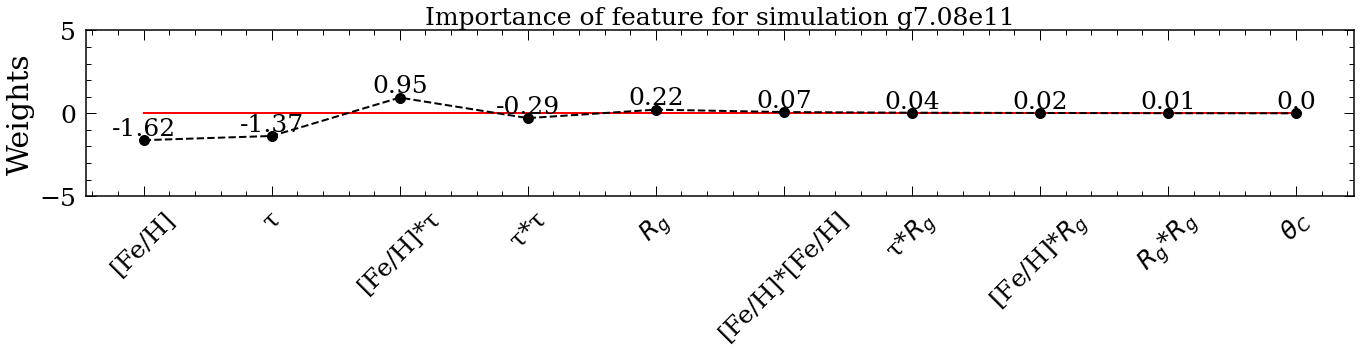

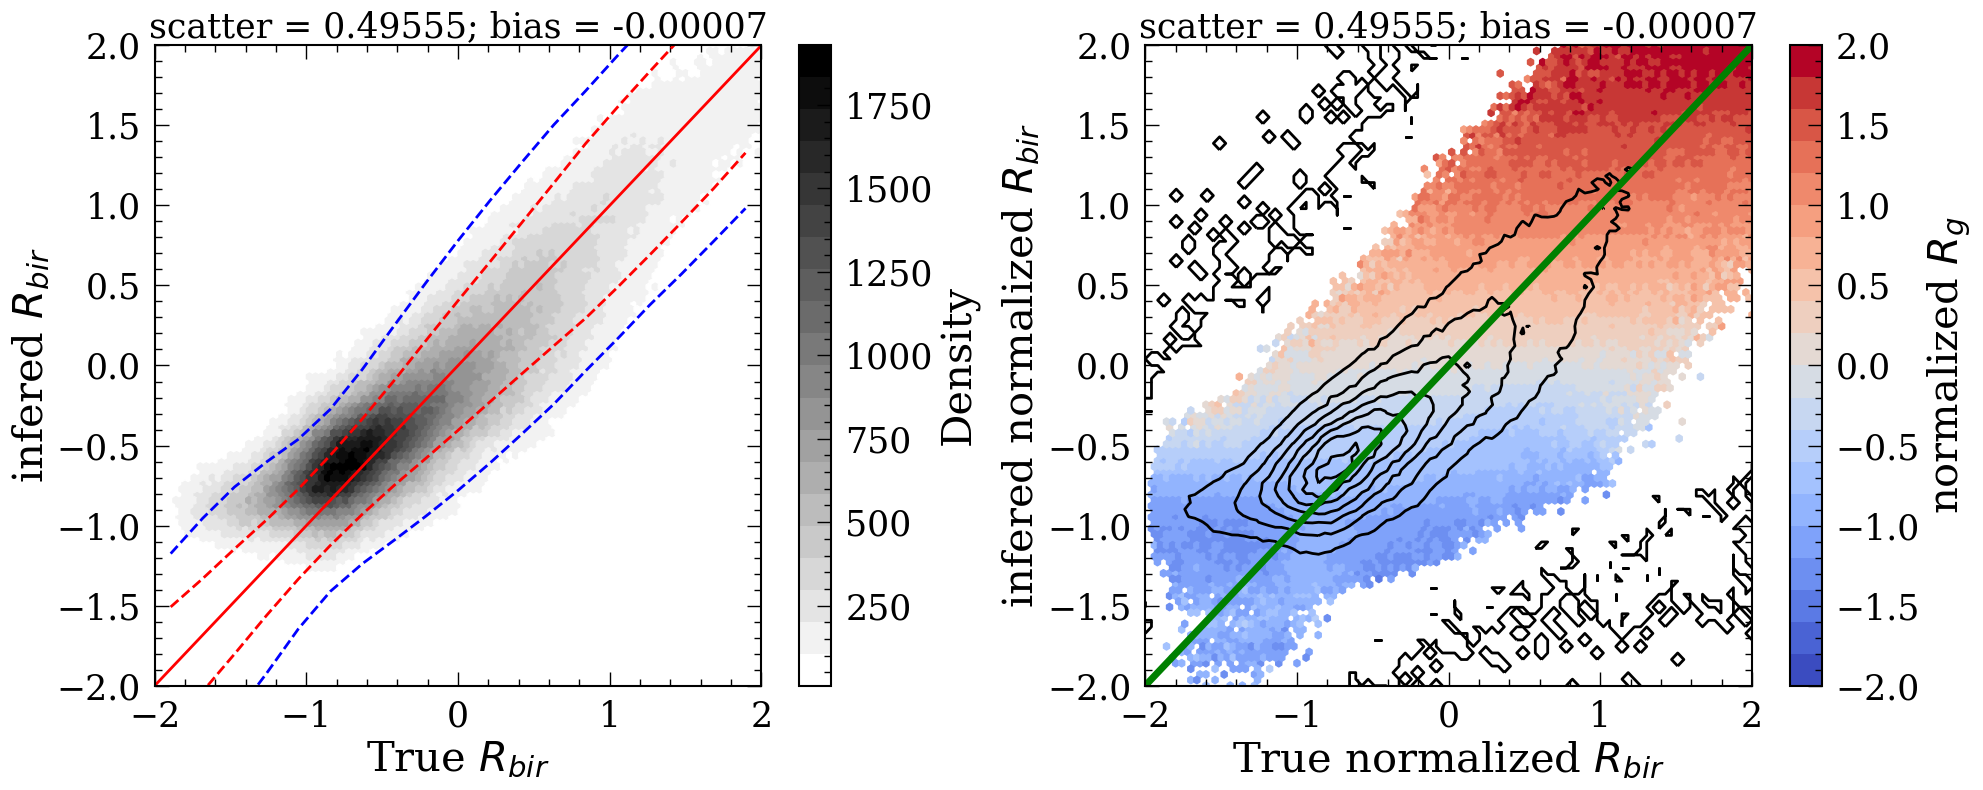

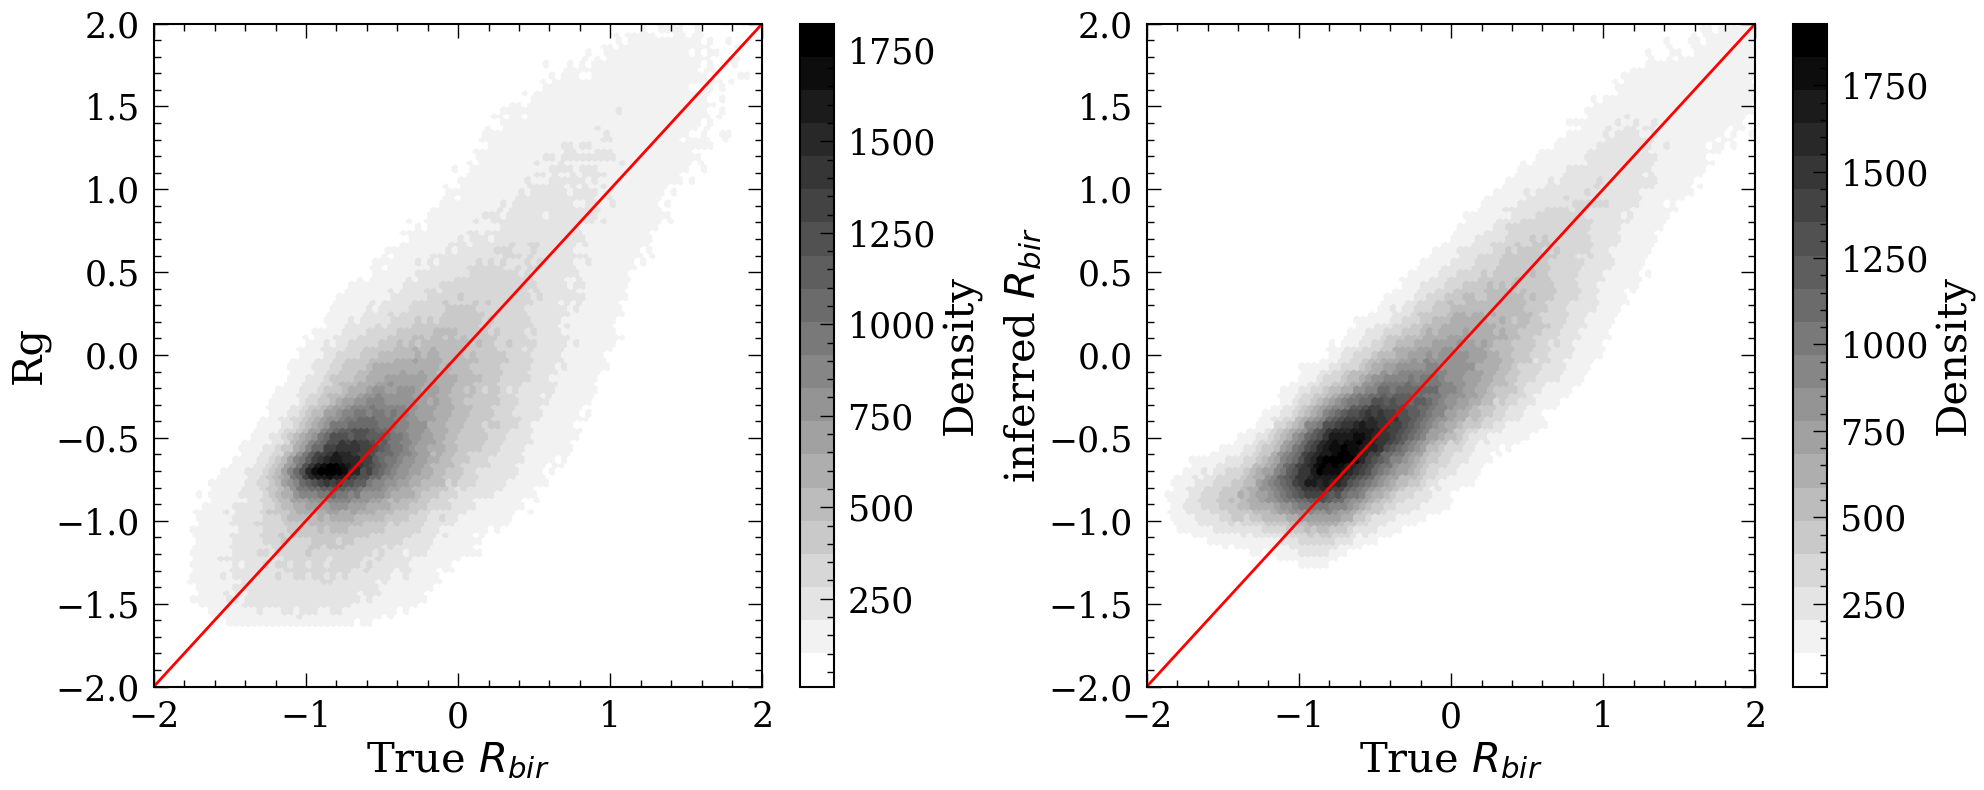

In [24]:
plt.figure(figsize=(19,5))
absweights, weights_imp, weights_imp_err, allnames_imp = zip(*sorted(zip(abs(np.array(weights)), weights, weights_err, allnames)))
weights_imp, allnames_imp = weights_imp[::-1], allnames_imp[::-1]
plt.errorbar(range(len(allnames_imp)), np.array(weights_imp), yerr=np.array(weights_imp_err), fmt='k--o', markersize=10)
plt.plot(range(len(allnames_imp)),np.zeros(len(allnames_imp)),'r-')
plt.xticks(range(len(allnames_imp)), allnames_imp, rotation=45)
#plt.xlabel('Features')
plt.ylabel('Weights')
plt.ylim([-5,5])
plt.title('Importance of feature for simulation g%s'%simsnames[i], fontsize=25)

for j, txt in enumerate(weights_imp):
    txt = np.round(txt,2)
    plt.annotate(txt, (j, weights_imp[j]),size=25,horizontalalignment='center', verticalalignment='bottom')
plt.tight_layout()
plt.savefig(simsnames[i]+'_importance.png')

xs = np.linspace(-2, 2, 100)


plt.figure(figsize=(20,8), dpi=100)
plt.subplot(1,2,1)
scatter = np.std(y-ypred)
bias  = np.mean(y-ypred)
cmap = plt.cm.get_cmap('binary',20)
plt.hexbin(y, ypred, extent=(-2,2,-2,2),gridsize=100, mincnt=10, cmap=cmap)

Rbirs, Rstds = calcRstd(data, Rbirbin=np.linspace(-2,2,20))
Rbirs_inf, Rstds_inf = calcRstd_inf(ypred, y, Rbirbin=np.linspace(-2,2,20))

plt.plot(Rbirs, Rbirs+Rstds, 'b--', label = '$σ_{rm}$')
plt.plot(Rbirs, Rbirs-Rstds, 'b--')
plt.plot(Rbirs_inf, Rbirs_inf-Rstds_inf, 'r--', label = '$σ_{inf}$')
plt.plot(Rbirs_inf, Rbirs_inf+Rstds_inf, 'r--')
plt.plot(xs, xs, "r-")
plt.xlim(-2, 2)
plt.ylim(-2, 2)
plt.xlabel("True $R_{bir}$")
plt.ylabel("infered $R_{bir}$")
plt.title('scatter = %.5f; bias = %.5f'%(scatter, bias),fontsize=25)
cb = plt.colorbar()
cb.set_label('Density')

plt.subplot(1,2,2)
cmap1 = plt.cm.get_cmap('coolwarm',20)
scatter = np.std(y-ypred)
bias  = np.mean(y-ypred)
plt.hexbin(y, ypred, C = normalize_data(data['Rg'].values), extent = (-2,2,-2,2), gridsize = 100, 
           cmap = cmap1, vmin = -2, vmax = 2, mincnt=10)
plt.plot(xs, xs, "g-", linewidth=5)
plt.xlim(-2, 2)
plt.ylim(-2, 2)
plt.xlabel("True normalized $R_{bir}$")
plt.ylabel("infered normalized $R_{bir}$")
plt.title('scatter = %.5f; bias = %.5f'%(scatter, bias),fontsize=25)
cb = plt.colorbar()
cb.set_label('normalized $R_g$')
from matplotlib.colors import LogNorm
counts,xbins,ybins=np.histogram2d(y, ypred, bins = (np.linspace(-2,2,100),np.linspace(-2,2,100)))
plt.contour(counts.transpose(),extent=[xbins.min(),xbins.max(),
    ybins.min(),ybins.max()],linewidths=2,colors='black',
    linestyles='solid')
plt.tight_layout()

plt.figure(figsize=(20,8), dpi=100)
plt.subplot(1,2,1)
plt.hexbin(normalize_data(data['Rbir']), normalize_data(data['Rg']), 
           extent=(-2,2,-2,2),gridsize=100, mincnt=10, cmap=cmap)

plt.plot(xs, xs, "r-")
plt.xlim(-2, 2)
plt.ylim(-2, 2)
plt.xlabel("True $R_{bir}$")
plt.ylabel("Rg")
#plt.title('scatter = %.5f; bias = %.5f'%(scatter, bias),fontsize=25)
cb = plt.colorbar()
cb.set_label('Density')

plt.subplot(1,2,2)
plt.hexbin(y, ypred, 
           extent=(-2,2,-2,2),gridsize=100, mincnt=10, cmap=cmap)

plt.plot(xs, xs, "r-")
plt.xlim(-2, 2)
plt.ylim(-2, 2)
plt.xlabel("True $R_{bir}$")
plt.ylabel("inferred $R_{bir}$")
#plt.title('scatter = %.5f; bias = %.5f'%(scatter, bias),fontsize=25)
cb = plt.colorbar()
cb.set_label('Density')

plt.tight_layout()

  0%|          | 0/6 [00:00<?, ?it/s]

6.96e11
Reading in simulation...
Finished reading in simulation...


 17%|█▋        | 1/6 [00:02<00:14,  2.92s/it]

8.26e11
Reading in simulation...
Finished reading in simulation...


/data/shared_data/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:261: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/data/shared_data/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:221: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/data/shared_data/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:253: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
 33%|███▎      | 2/6 [00:07<00:15,  3.99s/it]

7.08e11
Reading in simulation...
Finished reading in simulation...


 50%|█████     | 3/6 [00:12<00:13,  4.49s/it]

2.79e12
Reading in simulation...
Finished reading in simulation...


/data/shared_data/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:261: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/data/shared_data/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:221: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/data/shared_data/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:253: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
 83%|████████▎ | 5/6 [00:22<00:04,  4.62s/it]

7.55e11
Reading in simulation...
Finished reading in simulation...


/data/shared_data/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:261: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/data/shared_data/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:221: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/data/shared_data/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:253: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
100%|██████████| 6/6 [00:27<00:00,  4.60s/it]


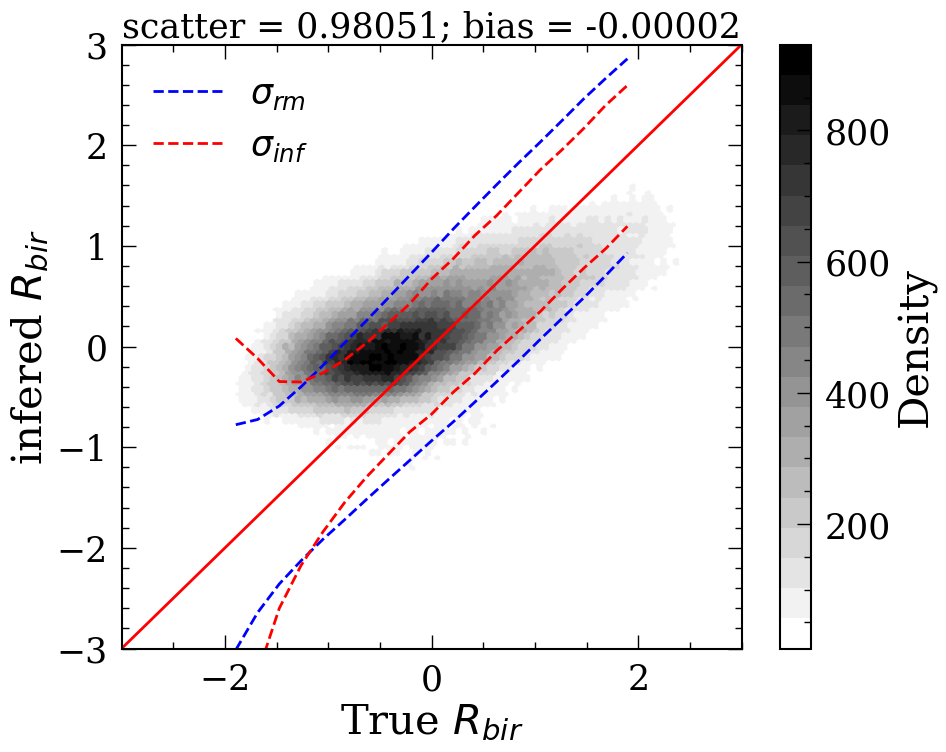

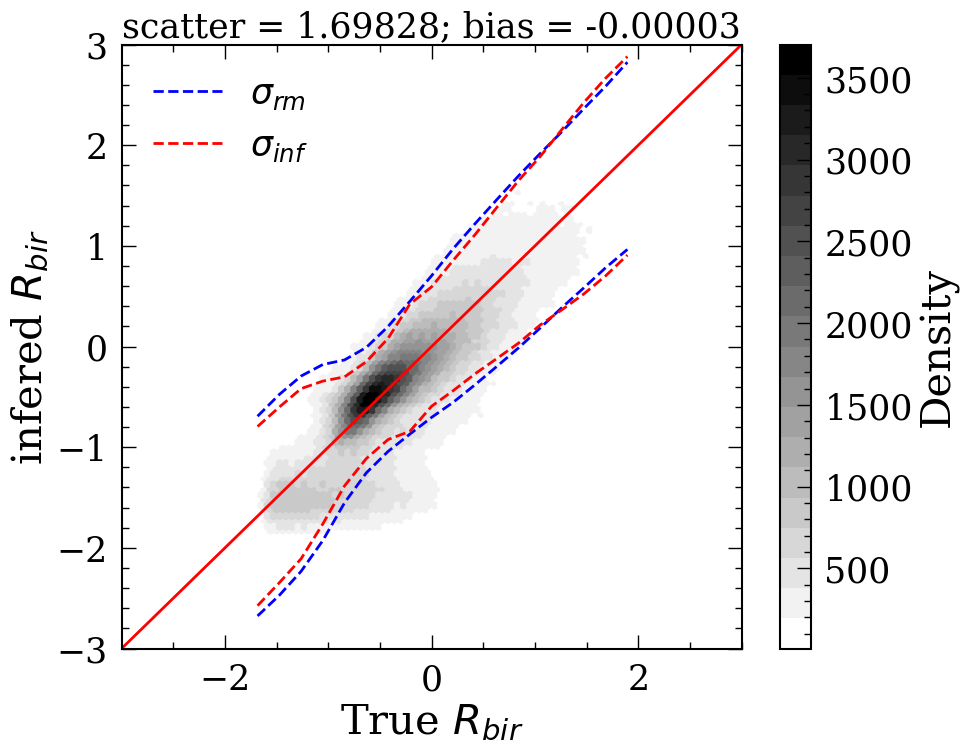

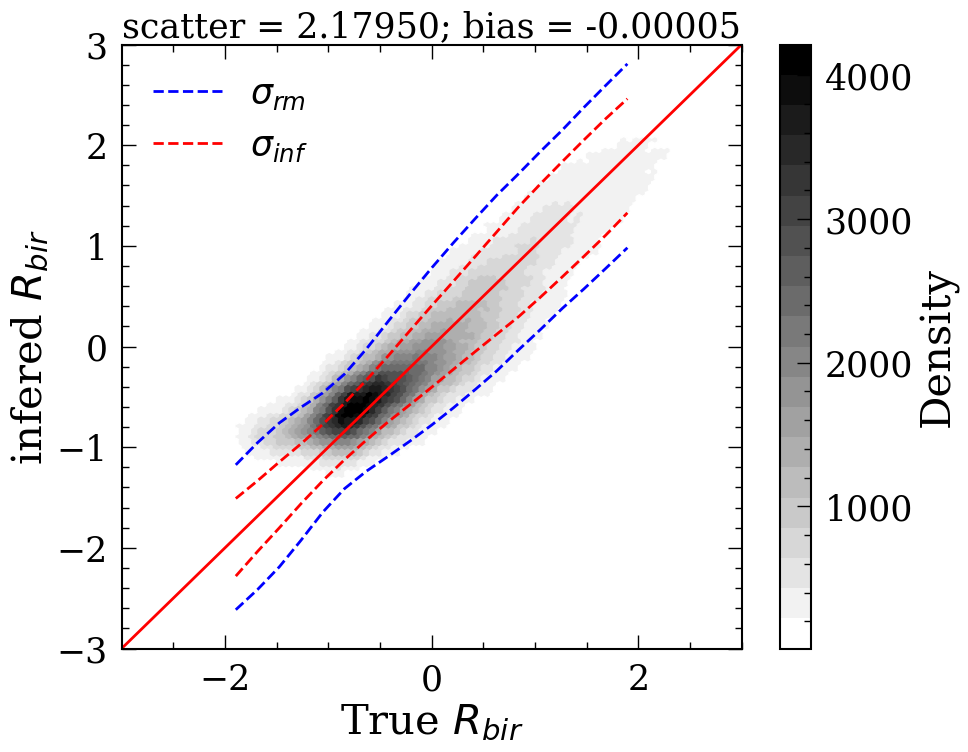

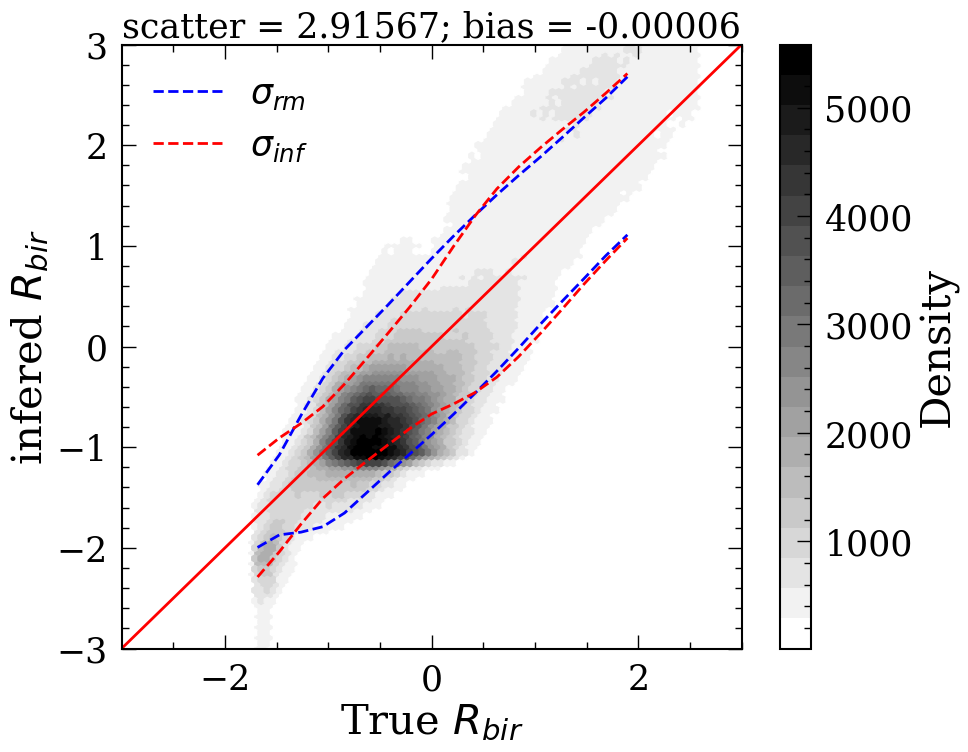

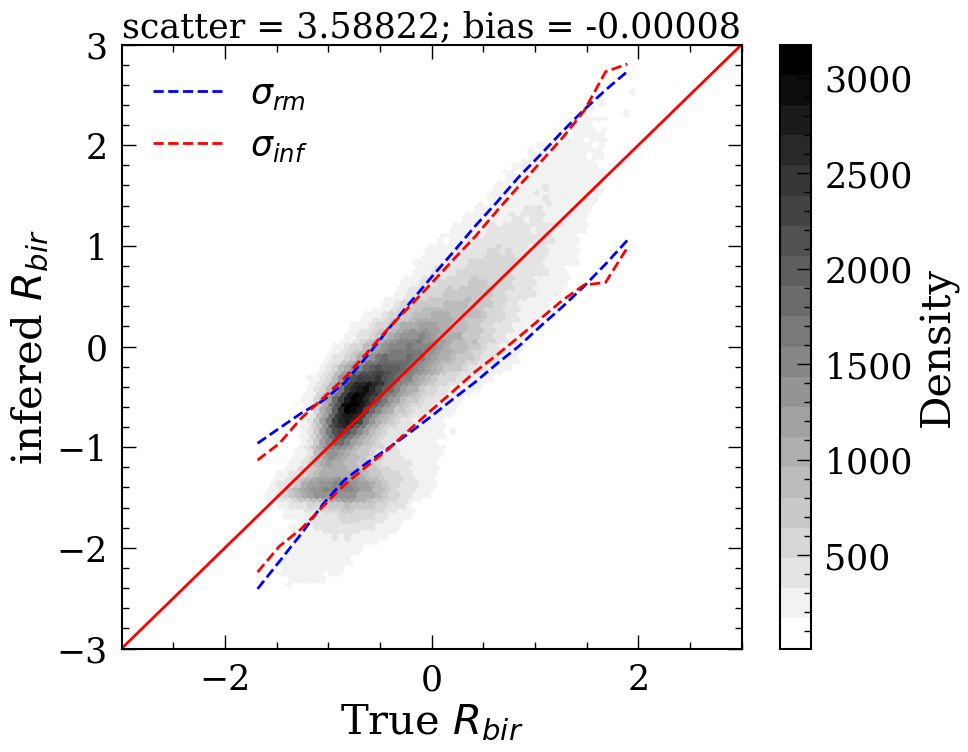

In [25]:
cmap = plt.cm.get_cmap('binary',20)
scatter, bias, diffinf = 0, 0, 0
for i in trange(len(simsnames)):
    if simsnames[i]=='1.12e12' or simsnames[i]==simNo:
        continue
    else:
        print(simsnames[i])
        
    simNo=simsnames[i]
    Rcut=True
    Rcut_thread=15
    zcut_thread=5
    
    print('Reading in simulation...')
    data = readsimdata(simNo,Rcut,Rcut_thread,zcut_thread)
    print('Finished reading in simulation...')

    y, ypred = predNew(weights, data)
    
    plt.figure(figsize=(10,8), dpi=100)
    scatter = np.std(y-ypred)+scatter
    bias  = np.mean(y-ypred)+bias
    
    plt.hexbin(y, ypred, extent=(-3,3,-3,3),gridsize=100, mincnt=10, cmap=cmap)
    Rbirs, Rstds = calcRstd(data, Rbirbin=np.linspace(-2,2,20))
    Rbirs_inf, Rstds_inf = calcRstd_inf(ypred, y, Rbirbin=np.linspace(-2,2,20))
    plt.plot(Rbirs, Rbirs+Rstds, 'b--', label = '$σ_{rm}$')
    plt.plot(Rbirs, Rbirs-Rstds, 'b--')
    plt.plot(Rbirs_inf, Rbirs_inf-Rstds_inf, 'r--', label = '$σ_{inf}$')
    plt.plot(Rbirs_inf, Rbirs_inf+Rstds_inf, 'r--')
    diffinf = diffinf+(Rstds-Rstds_inf)
    plt.plot([-3, 3], [-3, 3], "r-")
    plt.xlim(-3,3)
    plt.ylim(-3,3)
    plt.xlabel("True $R_{bir}$")
    plt.ylabel("infered $R_{bir}$")
    plt.title('scatter = %.5f; bias = %.5f'%(scatter, bias),fontsize=25)
    plt.legend()
    cb = plt.colorbar()
    cb.set_label('Density')
    plt.savefig(simsnames[i]+'_Rbirth_predW_model_disk_Rg'+simsnames[0]+'.png')
scatter = scatter/4
bias = bias/4
diffinf = np.mean(pd.Series(diffinf).dropna())/4

out708 = pd.DataFrame(np.array((np.append(allnames,['scatter','bias','scatter_pred',
                                                    'bias_pred','mean $σ_{rm}-σ_{inf}$']),
                               np.append(weights,[np.std(y-ypred),np.mean(y-ypred),scatter,bias,diffinf]), 
                               np.append(weights_err,[0, 0, 0, 0, 0]))).T,
                      columns=['names','w708','w_err708'])



Use 2.79e12

In [14]:
i=-2
simNo=simsnames[i]
Rcut=True
Rcut_thread=15
zcut_thread=5

print('Reading in simulation...')
data = readsimdata(simNo,Rcut,Rcut_thread,zcut_thread)
print('Finished reading in simulation...')

print('Calculating weights...')
data = data.dropna(subset=['Rg','feh'])
allnames, weights, weights_err, y, ypred = calcRbir_cv(data)
print('Finished calculating weights...')


Reading in simulation...
Finished reading in simulation...
Calculating weights...
Finished calculating weights...


/data/shared_data/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:261: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/data/shared_data/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:221: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/data/shared_data/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:253: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


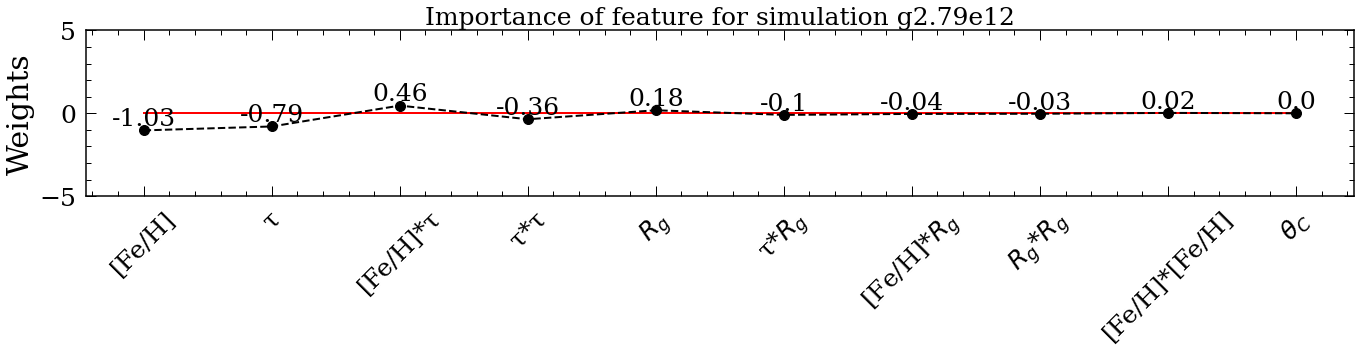

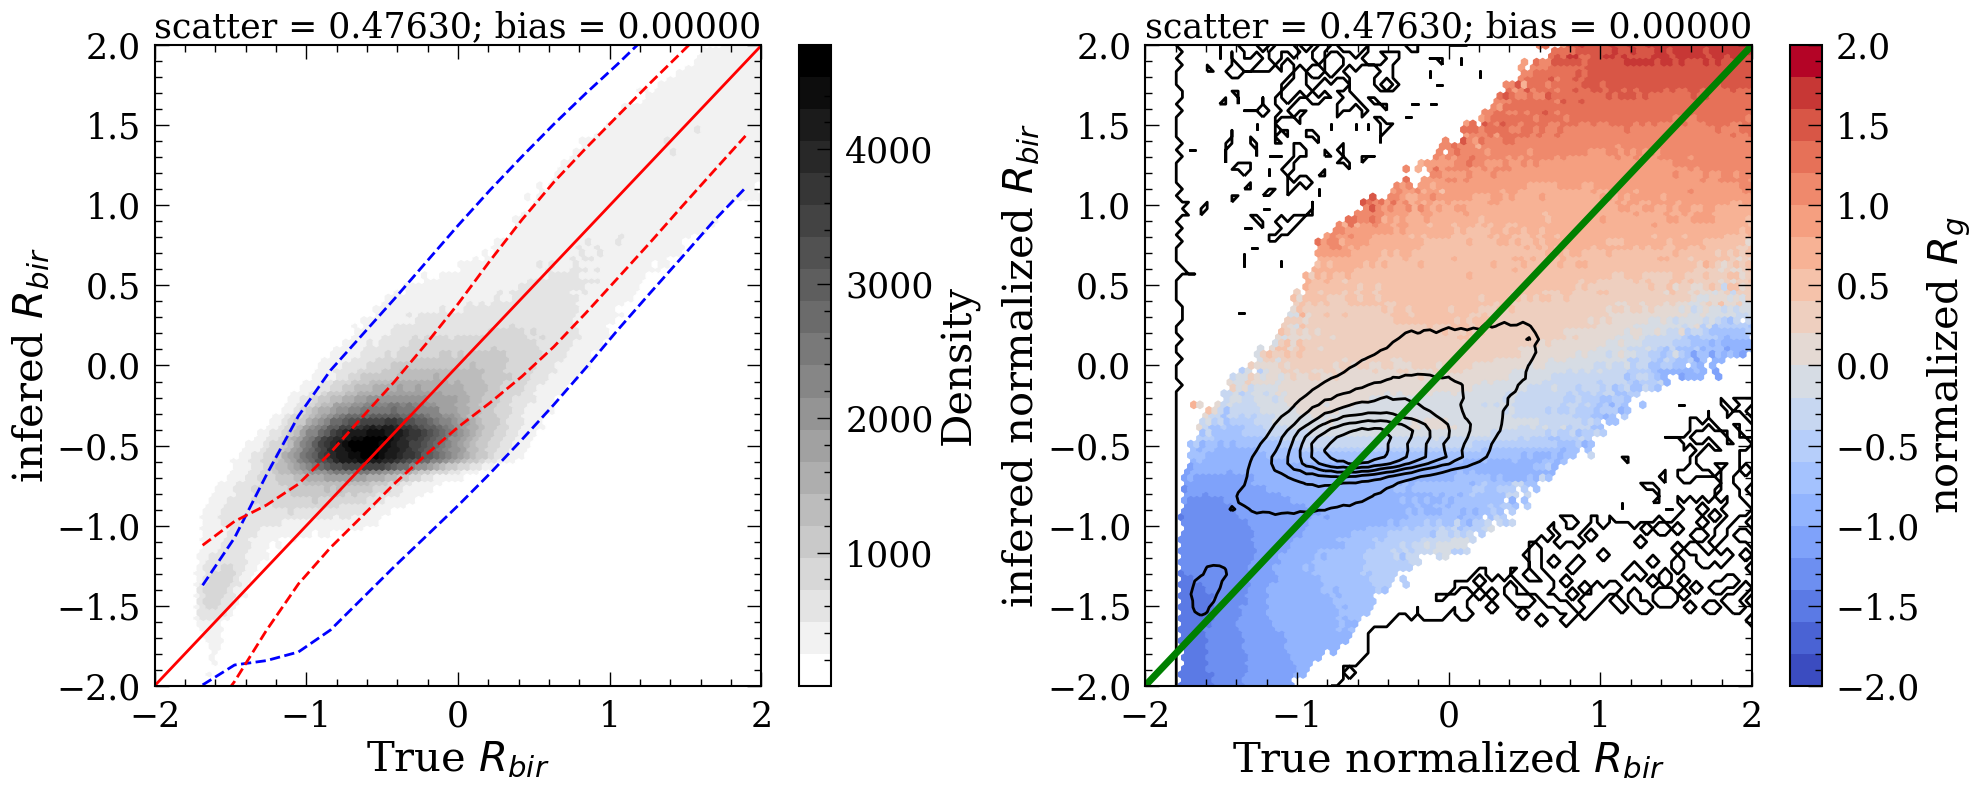

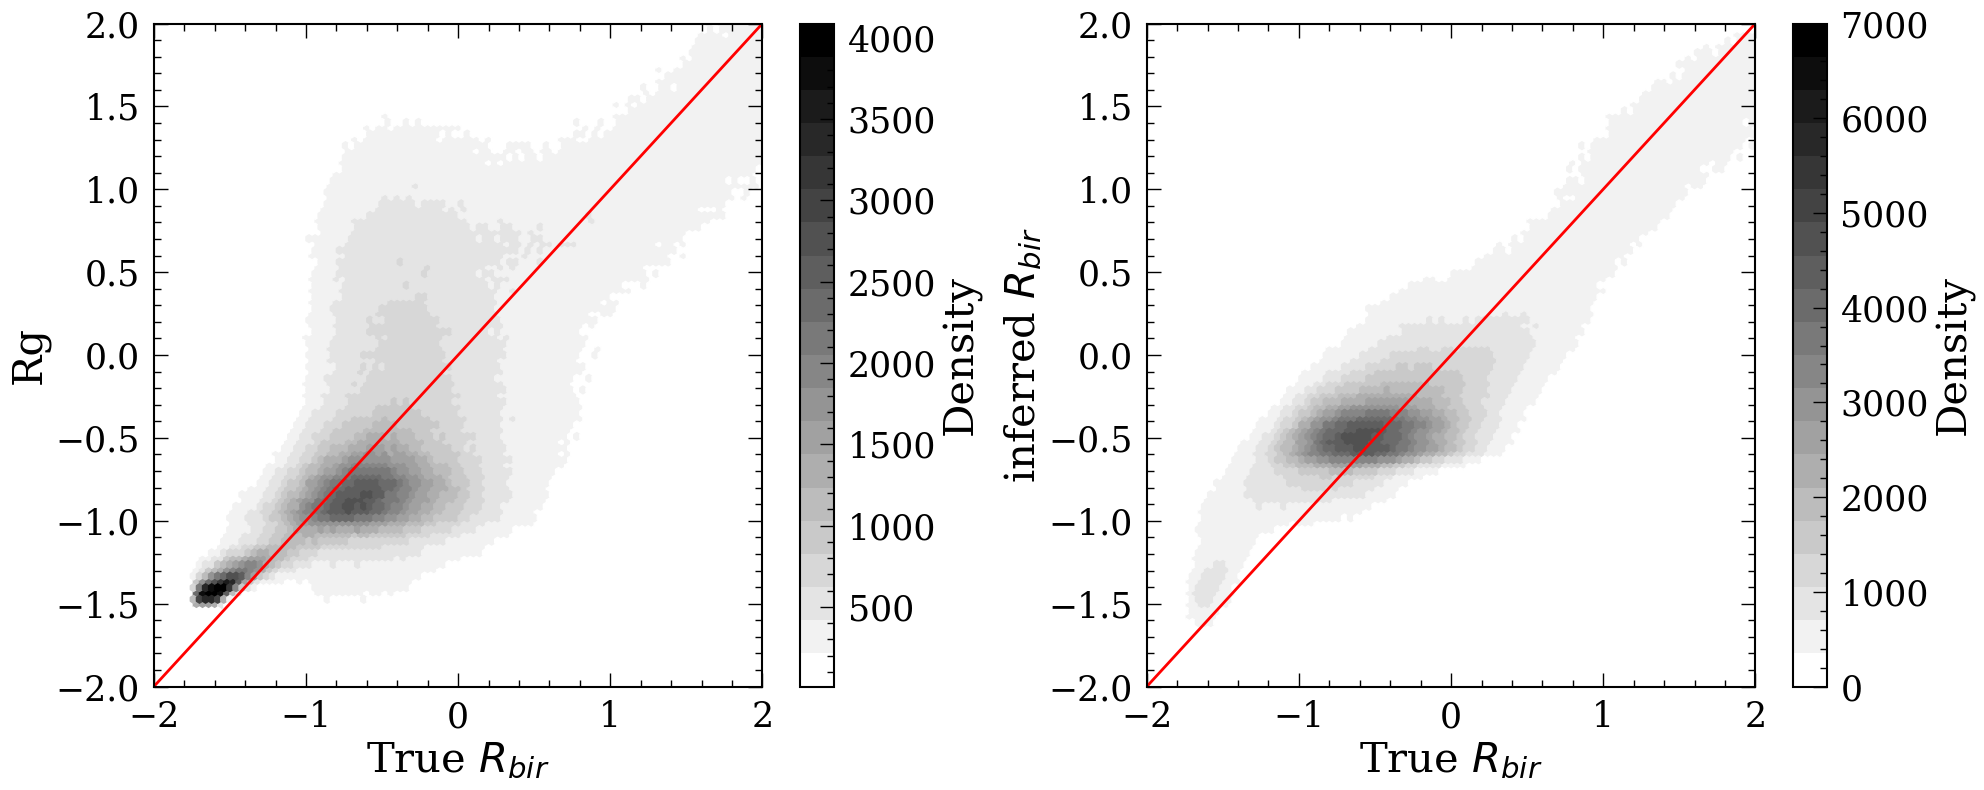

In [15]:
plt.figure(figsize=(19,5))
absweights, weights_imp, weights_imp_err, allnames_imp = zip(*sorted(zip(abs(np.array(weights)), weights, weights_err, allnames)))
weights_imp, allnames_imp = weights_imp[::-1], allnames_imp[::-1]
plt.errorbar(range(len(allnames_imp)), np.array(weights_imp), yerr=np.array(weights_imp_err), fmt='k--o', markersize=10)
plt.plot(range(len(allnames_imp)),np.zeros(len(allnames_imp)),'r-')
plt.xticks(range(len(allnames_imp)), allnames_imp, rotation=45)
#plt.xlabel('Features')
plt.ylabel('Weights')
plt.ylim([-5,5])
plt.title('Importance of feature for simulation g%s'%simsnames[i], fontsize=25)

for j, txt in enumerate(weights_imp):
    txt = np.round(txt,2)
    plt.annotate(txt, (j, weights_imp[j]),size=25,horizontalalignment='center', verticalalignment='bottom')
plt.tight_layout()
plt.savefig(simsnames[i]+'_importance.png')

xs = np.linspace(-2, 2, 100)


plt.figure(figsize=(20,8), dpi=100)
plt.subplot(1,2,1)
scatter = np.std(y-ypred)
bias  = np.mean(y-ypred)
cmap = plt.cm.get_cmap('binary',20)
plt.hexbin(y, ypred, extent=(-2,2,-2,2),gridsize=100, mincnt=10, cmap=cmap)

Rbirs, Rstds = calcRstd(data, Rbirbin=np.linspace(-2,2,20))
Rbirs_inf, Rstds_inf = calcRstd_inf(ypred, y, Rbirbin=np.linspace(-2,2,20))

plt.plot(Rbirs, Rbirs+Rstds, 'b--', label = '$σ_{rm}$')
plt.plot(Rbirs, Rbirs-Rstds, 'b--')
plt.plot(Rbirs_inf, Rbirs_inf-Rstds_inf, 'r--', label = '$σ_{inf}$')
plt.plot(Rbirs_inf, Rbirs_inf+Rstds_inf, 'r--')
plt.plot(xs, xs, "r-")
plt.xlim(-2, 2)
plt.ylim(-2, 2)
plt.xlabel("True $R_{bir}$")
plt.ylabel("infered $R_{bir}$")
plt.title('scatter = %.5f; bias = %.5f'%(scatter, bias),fontsize=25)
cb = plt.colorbar()
cb.set_label('Density')

plt.subplot(1,2,2)
cmap1 = plt.cm.get_cmap('coolwarm',20)
scatter = np.std(y-ypred)
bias  = np.mean(y-ypred)
plt.hexbin(y, ypred, C = normalize_data(data['Rg'].values), extent = (-2,2,-2,2), gridsize = 100, 
           cmap = cmap1, vmin = -2, vmax = 2, mincnt=10)
plt.plot(xs, xs, "g-", linewidth=5)
plt.xlim(-2, 2)
plt.ylim(-2, 2)
plt.xlabel("True normalized $R_{bir}$")
plt.ylabel("infered normalized $R_{bir}$")
plt.title('scatter = %.5f; bias = %.5f'%(scatter, bias),fontsize=25)
cb = plt.colorbar()
cb.set_label('normalized $R_g$')
from matplotlib.colors import LogNorm
counts,xbins,ybins=np.histogram2d(y, ypred, bins = (np.linspace(-2,2,100),np.linspace(-2,2,100)))
plt.contour(counts.transpose(),extent=[xbins.min(),xbins.max(),
    ybins.min(),ybins.max()],linewidths=2,colors='black',
    linestyles='solid')
plt.tight_layout()

plt.figure(figsize=(20,8), dpi=100)
plt.subplot(1,2,1)
plt.hexbin(normalize_data(data['Rbir']), normalize_data(data['Rg']), 
           extent=(-2,2,-2,2),gridsize=100, mincnt=10, cmap=cmap)

plt.plot(xs, xs, "r-")
plt.xlim(-2, 2)
plt.ylim(-2, 2)
plt.xlabel("True $R_{bir}$")
plt.ylabel("Rg")
#plt.title('scatter = %.5f; bias = %.5f'%(scatter, bias),fontsize=25)
cb = plt.colorbar()
cb.set_label('Density')

plt.subplot(1,2,2)
plt.hexbin(y, ypred, vmin=0, vmax=7000,
           extent=(-2,2,-2,2),gridsize=100, mincnt=10, cmap=cmap)

plt.plot(xs, xs, "r-")
plt.xlim(-2, 2)
plt.ylim(-2, 2)
plt.xlabel("True $R_{bir}$")
plt.ylabel("inferred $R_{bir}$")
#plt.title('scatter = %.5f; bias = %.5f'%(scatter, bias),fontsize=25)
cb = plt.colorbar()
cb.set_label('Density')

plt.tight_layout()

  0%|          | 0/6 [00:00<?, ?it/s]

6.96e11
Reading in simulation...
Finished reading in simulation...


 17%|█▋        | 1/6 [00:02<00:13,  2.80s/it]

8.26e11
Reading in simulation...
Finished reading in simulation...


/data/shared_data/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:261: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/data/shared_data/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:221: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/data/shared_data/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:253: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
 33%|███▎      | 2/6 [00:07<00:15,  3.79s/it]

7.08e11
Reading in simulation...
Finished reading in simulation...


 50%|█████     | 3/6 [00:12<00:13,  4.34s/it]

2.79e12
Reading in simulation...
Finished reading in simulation...


/data/shared_data/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:261: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/data/shared_data/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:221: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/data/shared_data/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:253: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
 83%|████████▎ | 5/6 [00:21<00:04,  4.60s/it]

7.55e11
Reading in simulation...
Finished reading in simulation...


/data/shared_data/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:261: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/data/shared_data/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:221: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/data/shared_data/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:253: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
100%|██████████| 6/6 [00:27<00:00,  4.53s/it]


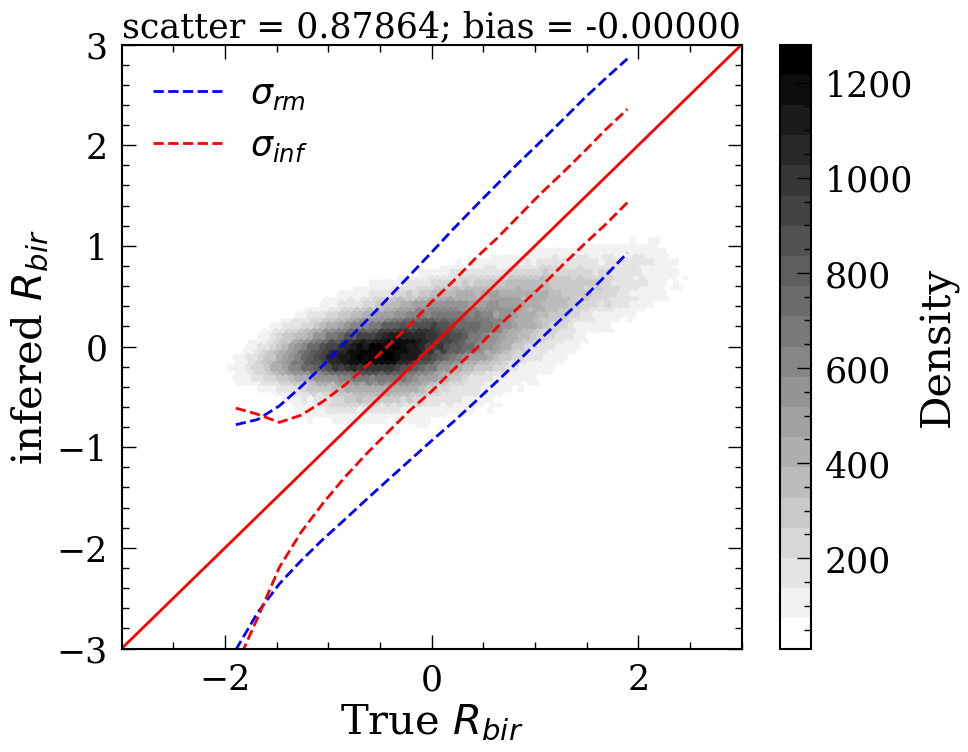

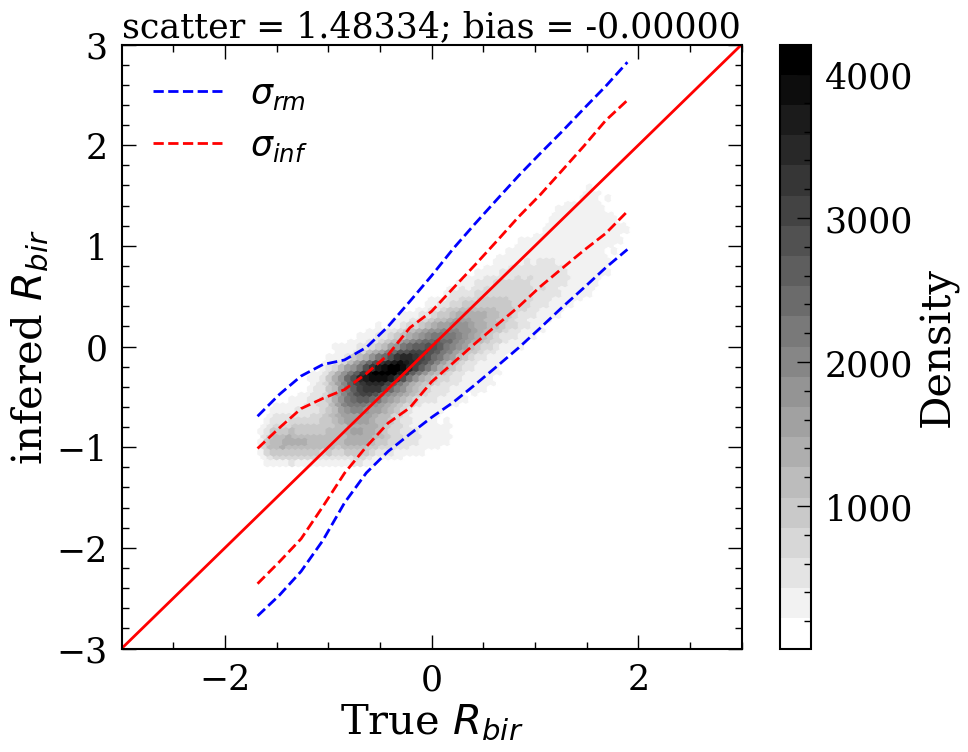

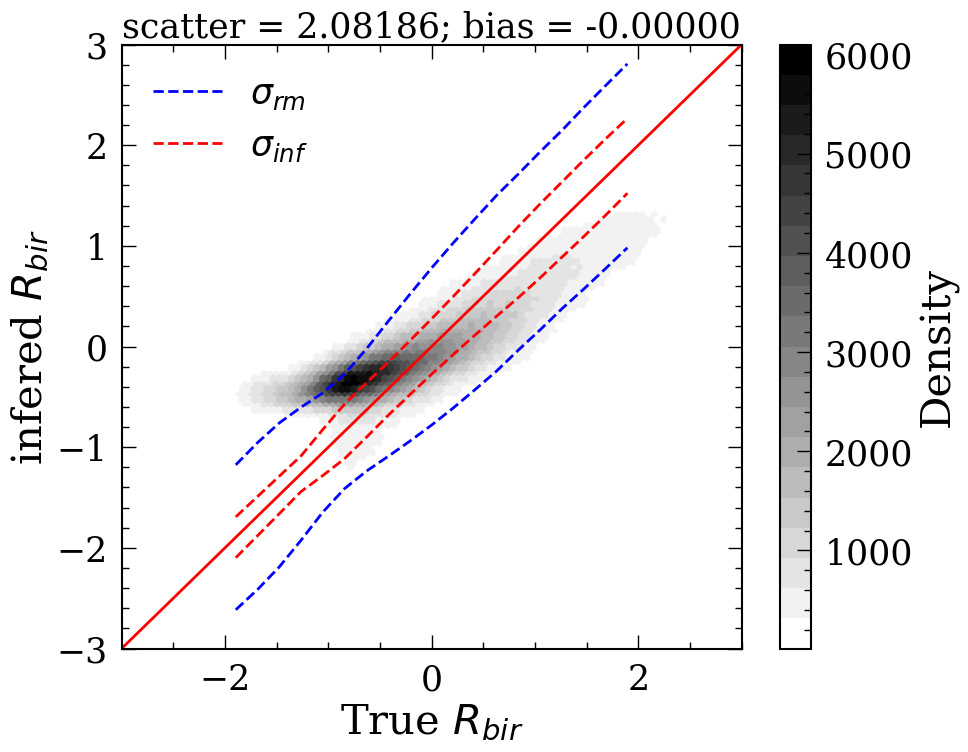

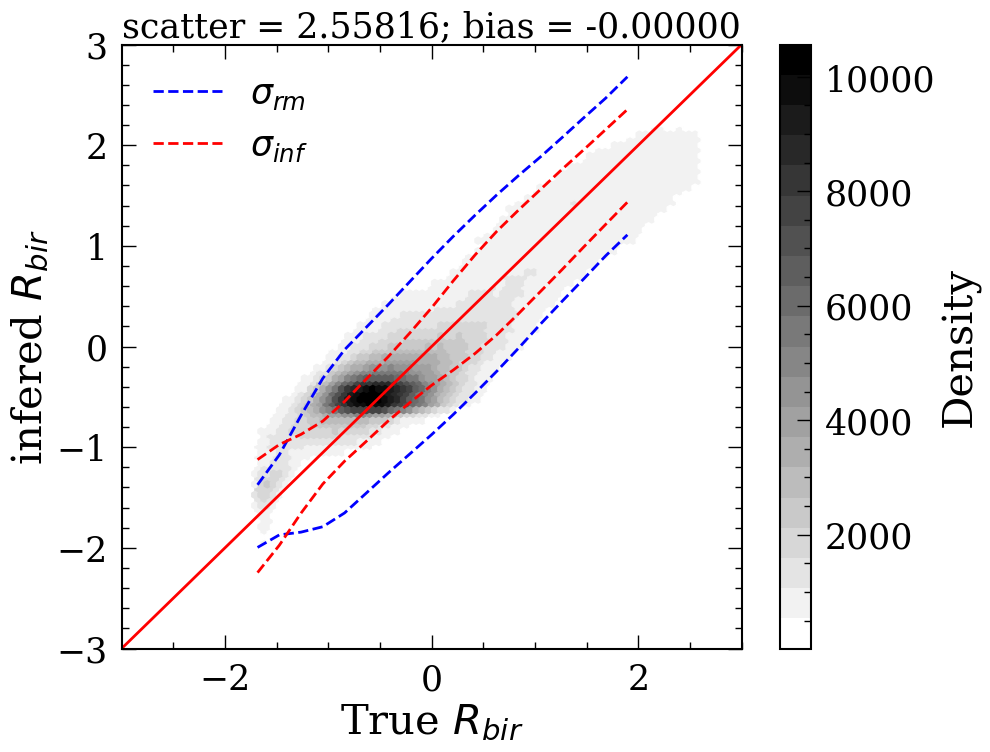

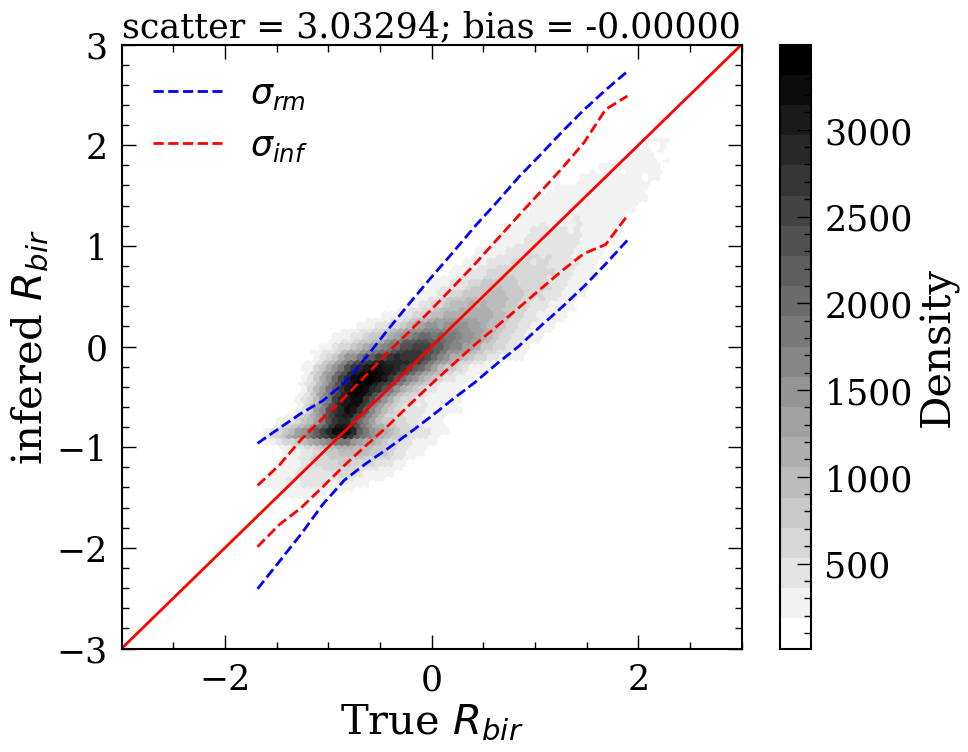

In [16]:
cmap = plt.cm.get_cmap('binary',20)
scatter, bias, diffinf = 0, 0, 0
for i in trange(len(simsnames)):
    if simsnames[i]=='1.12e12' or simsnames[i]==simNo:
        continue
    else:
        print(simsnames[i])
        
    simNo=simsnames[i]
    Rcut=True
    Rcut_thread=15
    zcut_thread=5
    
    print('Reading in simulation...')
    data = readsimdata(simNo,Rcut,Rcut_thread,zcut_thread)
    print('Finished reading in simulation...')

    y, ypred = predNew(weights, data)
    
    plt.figure(figsize=(10,8), dpi=100)
    scatter = np.std(y-ypred)+scatter
    bias  = np.mean(y-ypred)+bias
    
    plt.hexbin(y, ypred, extent=(-3,3,-3,3),gridsize=100, mincnt=10, cmap=cmap)
    Rbirs, Rstds = calcRstd(data, Rbirbin=np.linspace(-2,2,20))
    Rbirs_inf, Rstds_inf = calcRstd_inf(ypred, y, Rbirbin=np.linspace(-2,2,20))
    plt.plot(Rbirs, Rbirs+Rstds, 'b--', label = '$σ_{rm}$')
    plt.plot(Rbirs, Rbirs-Rstds, 'b--')
    plt.plot(Rbirs_inf, Rbirs_inf-Rstds_inf, 'r--', label = '$σ_{inf}$')
    plt.plot(Rbirs_inf, Rbirs_inf+Rstds_inf, 'r--')
    diffinf = diffinf+(Rstds-Rstds_inf)
    plt.plot([-3, 3], [-3, 3], "r-")
    plt.xlim(-3,3)
    plt.ylim(-3,3)
    plt.xlabel("True $R_{bir}$")
    plt.ylabel("infered $R_{bir}$")
    plt.title('scatter = %.5f; bias = %.5f'%(scatter, bias),fontsize=25)
    plt.legend()
    cb = plt.colorbar()
    cb.set_label('Density')
    plt.savefig(simsnames[i]+'_Rbirth_predW_model_disk_Rg'+simsnames[0]+'.png')
scatter = scatter/4
bias = bias/4
diffinf = np.mean(pd.Series(diffinf).dropna())/4

out279 = pd.DataFrame(np.array((np.append(allnames,['scatter','bias','scatter_pred',
                                                    'bias_pred','mean $σ_{rm}-σ_{inf}$']),
                               np.append(weights,[np.std(y-ypred),np.mean(y-ypred),scatter,bias,diffinf]), 
                               np.append(weights_err,[0, 0, 0, 0, 0]))).T,
                      columns=['names','w279','w_err279'])



Use 7.55e11

In [17]:
i=-1
simNo=simsnames[i]
Rcut=True
Rcut_thread=15
zcut_thread=5

print('Reading in simulation...')
data = readsimdata(simNo,Rcut,Rcut_thread,zcut_thread)
print('Finished reading in simulation...')

print('Calculating weights...')
allnames, weights, weights_err, y, ypred = calcRbir_cv(data)
print('Finished calculating weights...')


Reading in simulation...
Finished reading in simulation...
Calculating weights...
Finished calculating weights...


In [18]:
"""
allsnaps = glob.glob(sims[i]+'/*.?????')
    
allsnaps_time = [int(i.split('.')[-1]) for i in allsnaps if (('param' not in i) and ('draco' not in i) and ('dat_' not in i) and ('79e12' not in i.split('.')[-1]))]
snaplookup = {int(allsnaps[i].split('.')[-1]):allsnaps[i] for i in range(len(allsnaps)) if (('param' not in allsnaps[i]) and ('draco' not in allsnaps[i]) and ('dat_' not in allsnaps[i]) and ('79e12' not in allsnaps[i].split('.')[-1]))}
snap = snaplookup[max(allsnaps_time)]

print(snap)
s = pb.load(snap)
h=s.halos()
pb.analysis.angmom.faceon(h[1])
s.physical_units()
p = pb.analysis.profile.Profile(h[1],rmin=.01,rmax =250,type='log',ndim=3)
pg = pb.analysis.profile.Profile(h[1].g,rmin=.01,rmax =250,type='log',ndim=3)
ps = pb.analysis.profile.Profile(h[1].s,rmin=.01,rmax =250,type='log',ndim=3)
pd = pb.analysis.profile.Profile(h[1].d,rmin=.01,rmax =250,type='log',ndim=3)


f = interp1d(p['rbins'], p['v_circ'])
vphis = np.zeros(len(data))*np.nan
vphis[data['R'].values>=min(p['rbins'])] = f(data['R'].values[data['R'].values>=min(p['rbins'])])
data['vc'] = vphis

data['Rg']=data['vcxy']*data['R']/data['vc']


data.to_pickle('./g'+simNo+'_z_0_decomp.pkl')


"""

"\nallsnaps = glob.glob(sims[i]+'/*.?????')\n    \nallsnaps_time = [int(i.split('.')[-1]) for i in allsnaps if (('param' not in i) and ('draco' not in i) and ('dat_' not in i) and ('79e12' not in i.split('.')[-1]))]\nsnaplookup = {int(allsnaps[i].split('.')[-1]):allsnaps[i] for i in range(len(allsnaps)) if (('param' not in allsnaps[i]) and ('draco' not in allsnaps[i]) and ('dat_' not in allsnaps[i]) and ('79e12' not in allsnaps[i].split('.')[-1]))}\nsnap = snaplookup[max(allsnaps_time)]\n\nprint(snap)\ns = pb.load(snap)\nh=s.halos()\npb.analysis.angmom.faceon(h[1])\ns.physical_units()\np = pb.analysis.profile.Profile(h[1],rmin=.01,rmax =250,type='log',ndim=3)\npg = pb.analysis.profile.Profile(h[1].g,rmin=.01,rmax =250,type='log',ndim=3)\nps = pb.analysis.profile.Profile(h[1].s,rmin=.01,rmax =250,type='log',ndim=3)\npd = pb.analysis.profile.Profile(h[1].d,rmin=.01,rmax =250,type='log',ndim=3)\n\n\nf = interp1d(p['rbins'], p['v_circ'])\nvphis = np.zeros(len(data))*np.nan\nvphis[data['R']

/data/shared_data/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:261: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/data/shared_data/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:221: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/data/shared_data/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:253: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


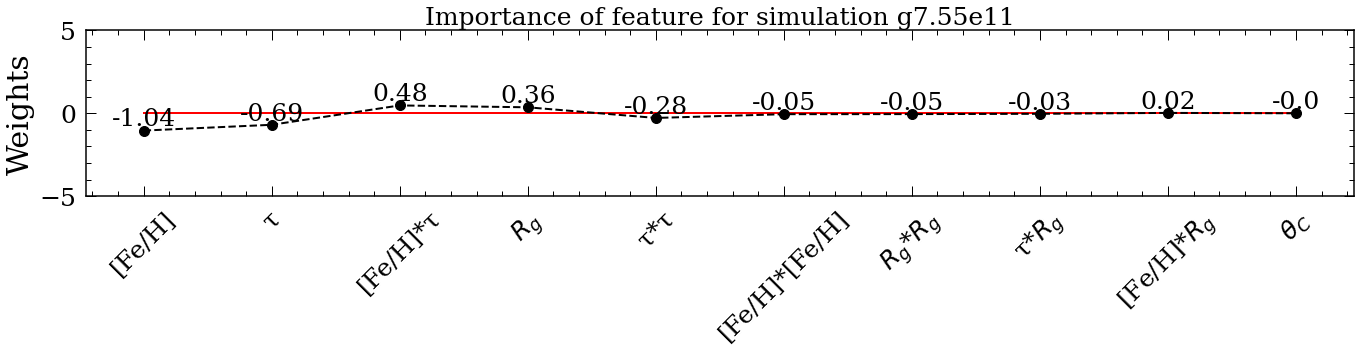

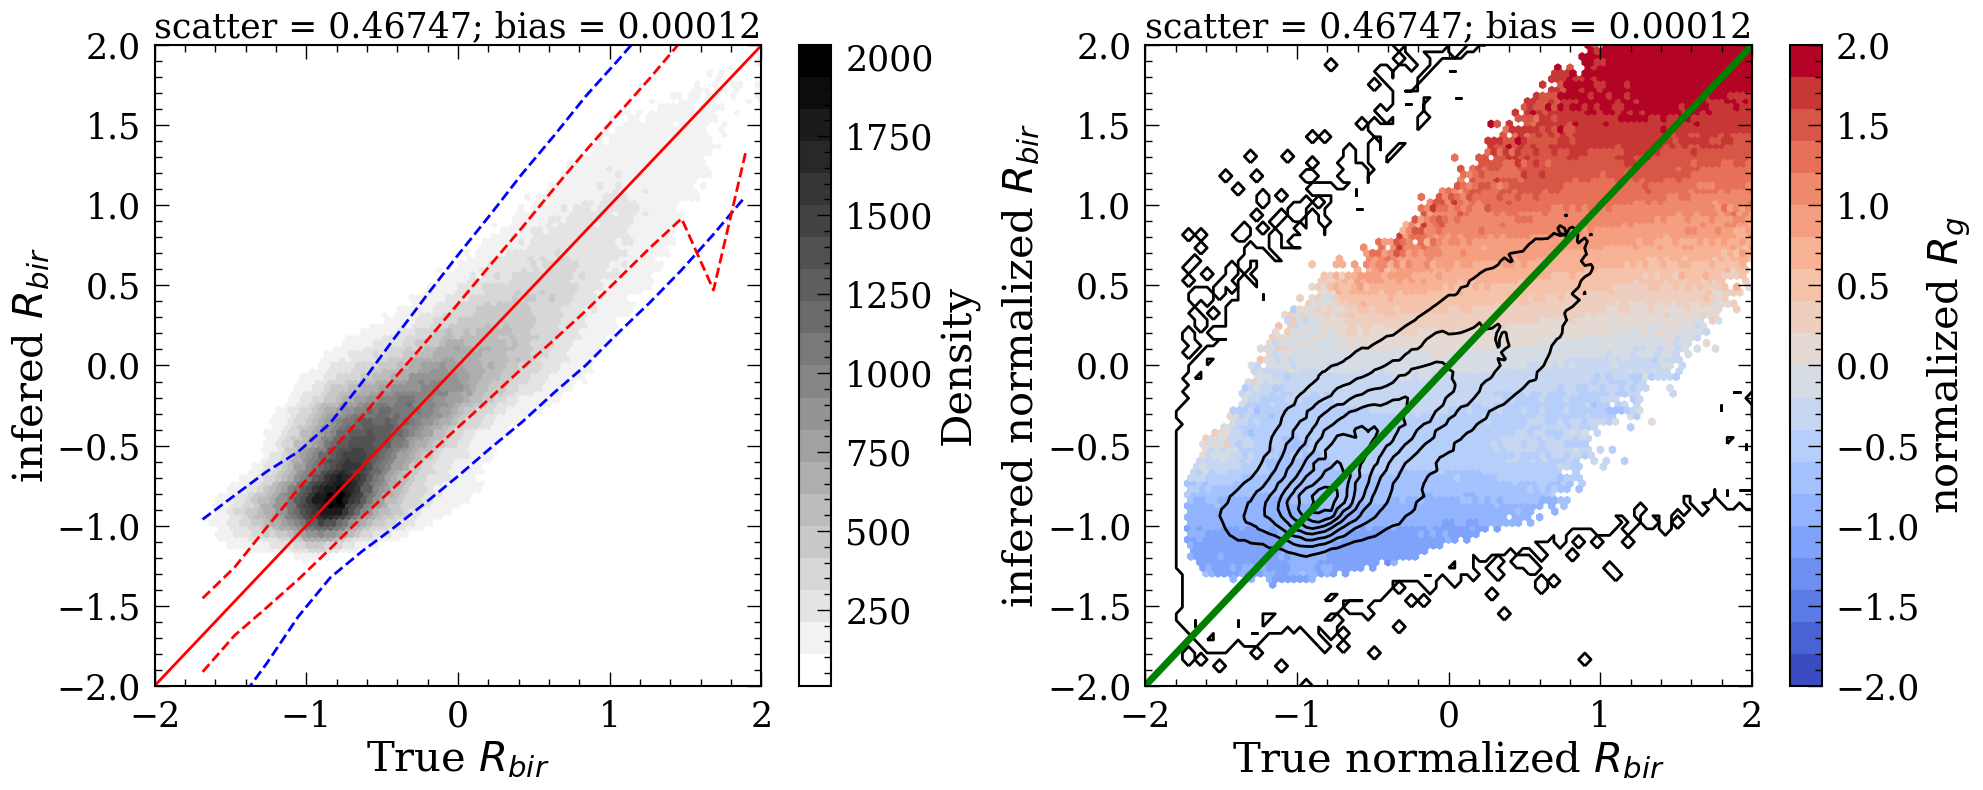

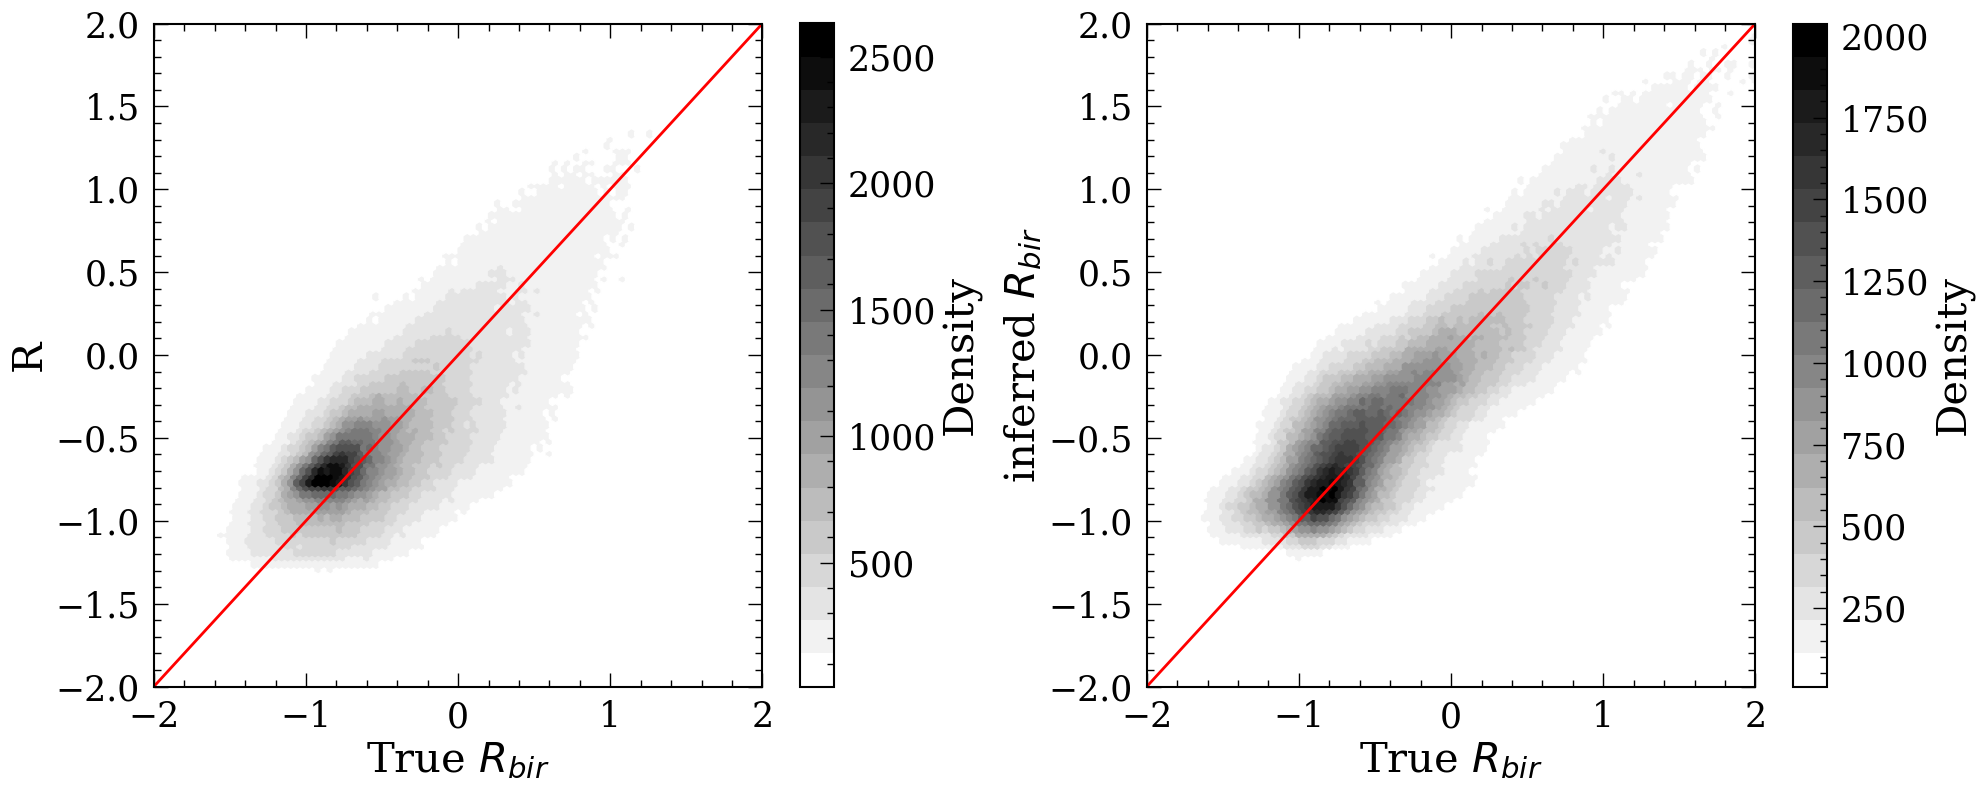

In [20]:
plt.figure(figsize=(19,5))
absweights, weights_imp, weights_imp_err, allnames_imp = zip(*sorted(zip(abs(np.array(weights)), weights, weights_err, allnames)))
weights_imp, allnames_imp = weights_imp[::-1], allnames_imp[::-1]
plt.errorbar(range(len(allnames_imp)), np.array(weights_imp), yerr=np.array(weights_imp_err), fmt='k--o', markersize=10)
plt.plot(range(len(allnames_imp)),np.zeros(len(allnames_imp)),'r-')
plt.xticks(range(len(allnames_imp)), allnames_imp, rotation=45)
#plt.xlabel('Features')
plt.ylabel('Weights')
plt.ylim([-5,5])
plt.title('Importance of feature for simulation g%s'%simsnames[i], fontsize=25)

for j, txt in enumerate(weights_imp):
    txt = np.round(txt,2)
    plt.annotate(txt, (j, weights_imp[j]),size=25,horizontalalignment='center', verticalalignment='bottom')
plt.tight_layout()
plt.savefig(simsnames[i]+'_importance.png')

xs = np.linspace(-2, 2, 100)


plt.figure(figsize=(20,8), dpi=100)
plt.subplot(1,2,1)
scatter = np.std(y-ypred)
bias  = np.mean(y-ypred)
cmap = plt.cm.get_cmap('binary',20)
plt.hexbin(y, ypred, extent=(-2,2,-2,2),gridsize=100, mincnt=10, cmap=cmap)

Rbirs, Rstds = calcRstd(data, Rbirbin=np.linspace(-2,2,20))
Rbirs_inf, Rstds_inf = calcRstd_inf(ypred, y, Rbirbin=np.linspace(-2,2,20))

plt.plot(Rbirs, Rbirs+Rstds, 'b--', label = '$σ_{rm}$')
plt.plot(Rbirs, Rbirs-Rstds, 'b--')
plt.plot(Rbirs_inf, Rbirs_inf-Rstds_inf, 'r--', label = '$σ_{inf}$')
plt.plot(Rbirs_inf, Rbirs_inf+Rstds_inf, 'r--')
plt.plot(xs, xs, "r-")
plt.xlim(-2, 2)
plt.ylim(-2, 2)
plt.xlabel("True $R_{bir}$")
plt.ylabel("infered $R_{bir}$")
plt.title('scatter = %.5f; bias = %.5f'%(scatter, bias),fontsize=25)
cb = plt.colorbar()
cb.set_label('Density')

plt.subplot(1,2,2)
cmap1 = plt.cm.get_cmap('coolwarm',20)
scatter = np.std(y-ypred)
bias  = np.mean(y-ypred)
plt.hexbin(y, ypred, C = normalize_data(data['Rg'].values), extent = (-2,2,-2,2), gridsize = 100, 
           cmap = cmap1, vmin = -2, vmax = 2, mincnt=10)
plt.plot(xs, xs, "g-", linewidth=5)
plt.xlim(-2, 2)
plt.ylim(-2, 2)
plt.xlabel("True normalized $R_{bir}$")
plt.ylabel("infered normalized $R_{bir}$")
plt.title('scatter = %.5f; bias = %.5f'%(scatter, bias),fontsize=25)
cb = plt.colorbar()
cb.set_label('normalized $R_g$')
from matplotlib.colors import LogNorm
counts,xbins,ybins=np.histogram2d(y, ypred, bins = (np.linspace(-2,2,100),np.linspace(-2,2,100)))
plt.contour(counts.transpose(),extent=[xbins.min(),xbins.max(),
    ybins.min(),ybins.max()],linewidths=2,colors='black',
    linestyles='solid')
plt.tight_layout()



plt.figure(figsize=(20,8), dpi=100)
plt.subplot(1,2,1)
plt.hexbin(normalize_data(data['Rbir']), normalize_data(data['Rg']), 
           extent=(-2,2,-2,2),gridsize=100, mincnt=10, cmap=cmap)

plt.plot(xs, xs, "r-")
plt.xlim(-2, 2)
plt.ylim(-2, 2)
plt.xlabel("True $R_{bir}$")
plt.ylabel("R")
#plt.title('scatter = %.5f; bias = %.5f'%(scatter, bias),fontsize=25)
cb = plt.colorbar()
cb.set_label('Density')

plt.subplot(1,2,2)
plt.hexbin(y, ypred, 
           extent=(-2,2,-2,2),gridsize=100, mincnt=10, cmap=cmap)

plt.plot(xs, xs, "r-")
plt.xlim(-2, 2)
plt.ylim(-2, 2)
plt.xlabel("True $R_{bir}$")
plt.ylabel("inferred $R_{bir}$")
#plt.title('scatter = %.5f; bias = %.5f'%(scatter, bias),fontsize=25)
cb = plt.colorbar()
cb.set_label('Density')

plt.tight_layout()



  0%|          | 0/6 [00:00<?, ?it/s]

6.96e11
Reading in simulation...
Finished reading in simulation...


 17%|█▋        | 1/6 [00:02<00:14,  2.88s/it]

8.26e11
Reading in simulation...
Finished reading in simulation...


/data/shared_data/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:261: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/data/shared_data/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:221: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/data/shared_data/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:253: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
 33%|███▎      | 2/6 [00:07<00:15,  3.87s/it]

7.08e11
Reading in simulation...
Finished reading in simulation...


 50%|█████     | 3/6 [00:12<00:13,  4.40s/it]

2.79e12
Reading in simulation...
Finished reading in simulation...


/data/shared_data/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:261: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/data/shared_data/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:221: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/data/shared_data/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:253: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
 83%|████████▎ | 5/6 [00:21<00:04,  4.57s/it]

7.55e11
Reading in simulation...
Finished reading in simulation...


/data/shared_data/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:261: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/data/shared_data/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:221: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/data/shared_data/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:253: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
100%|██████████| 6/6 [00:27<00:00,  4.54s/it]


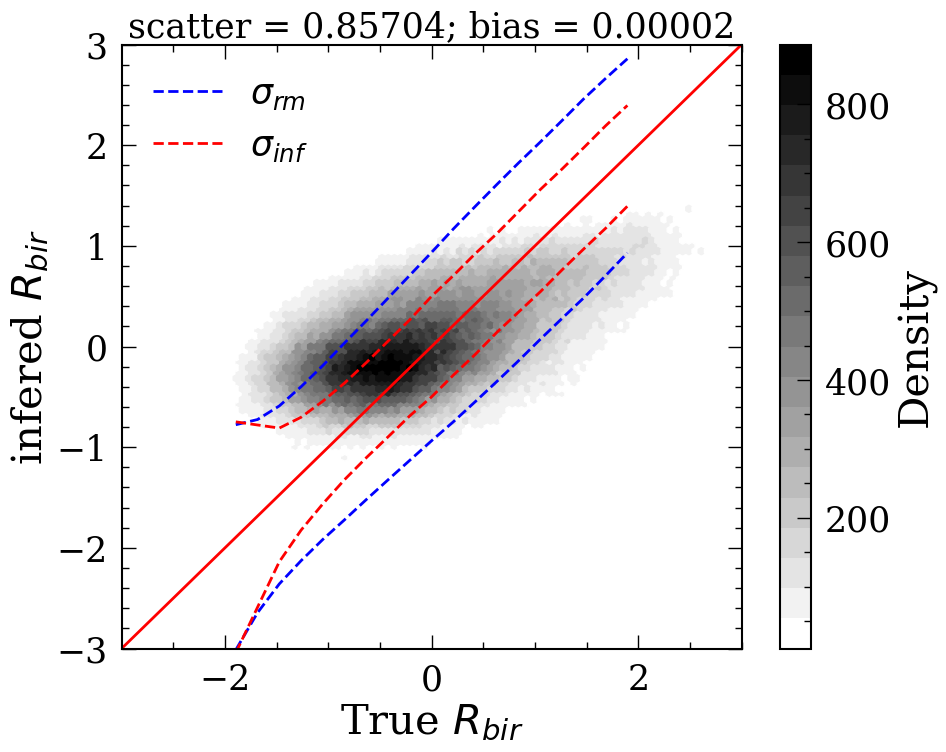

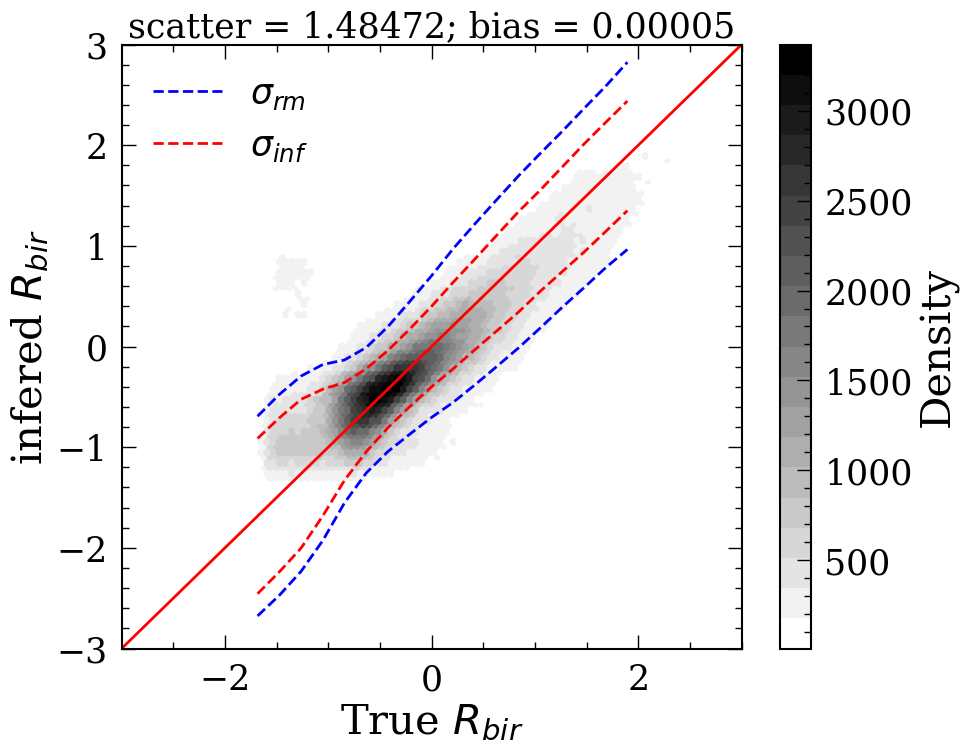

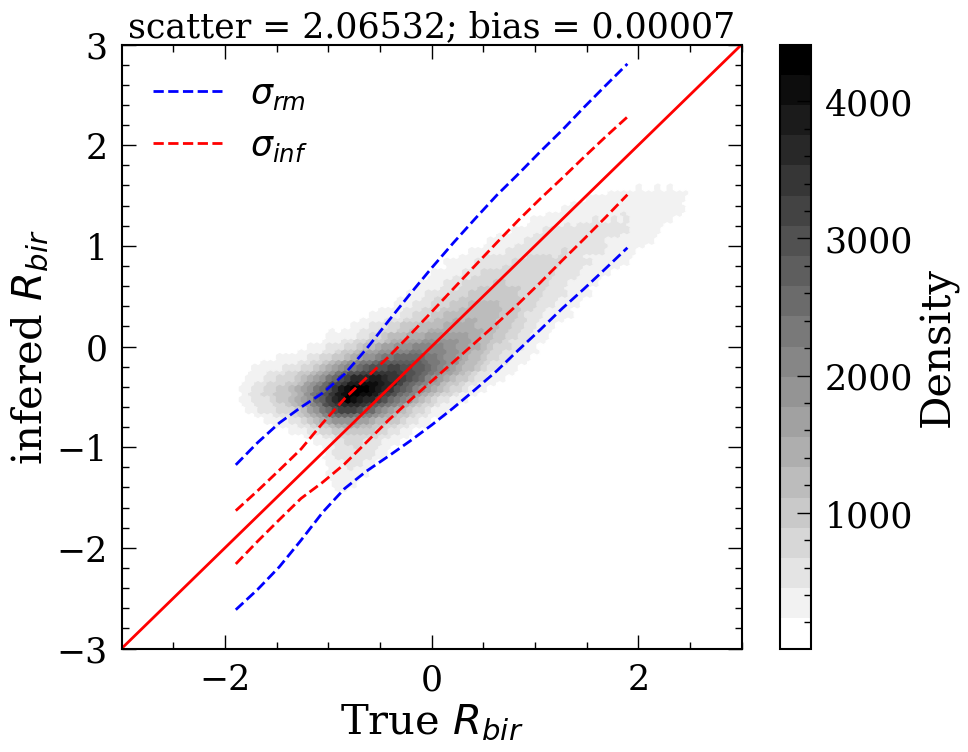

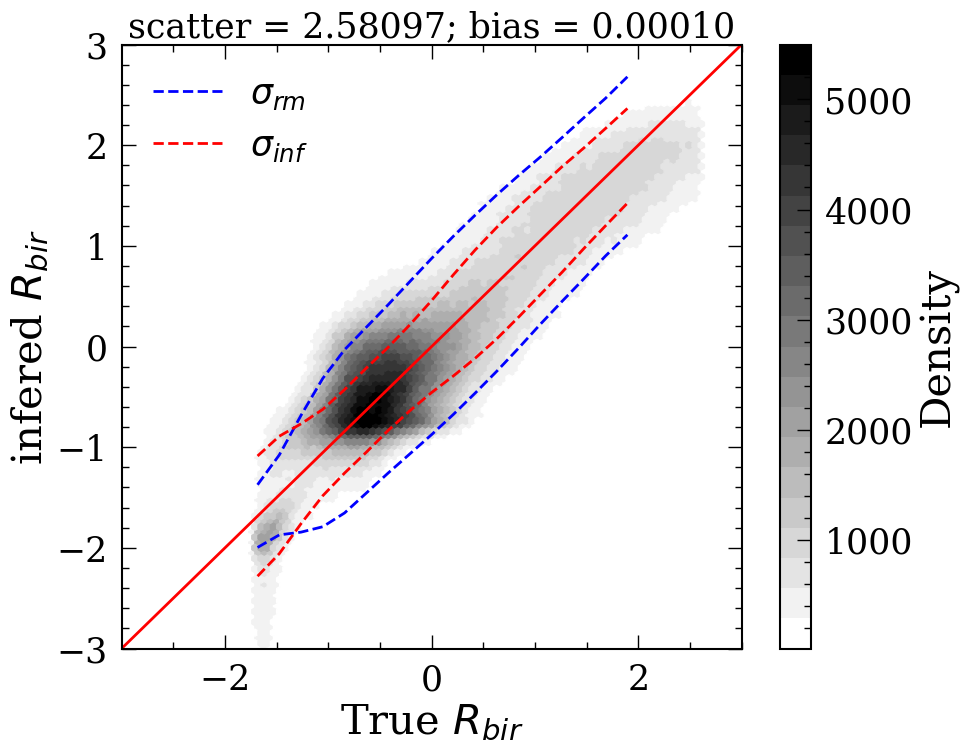

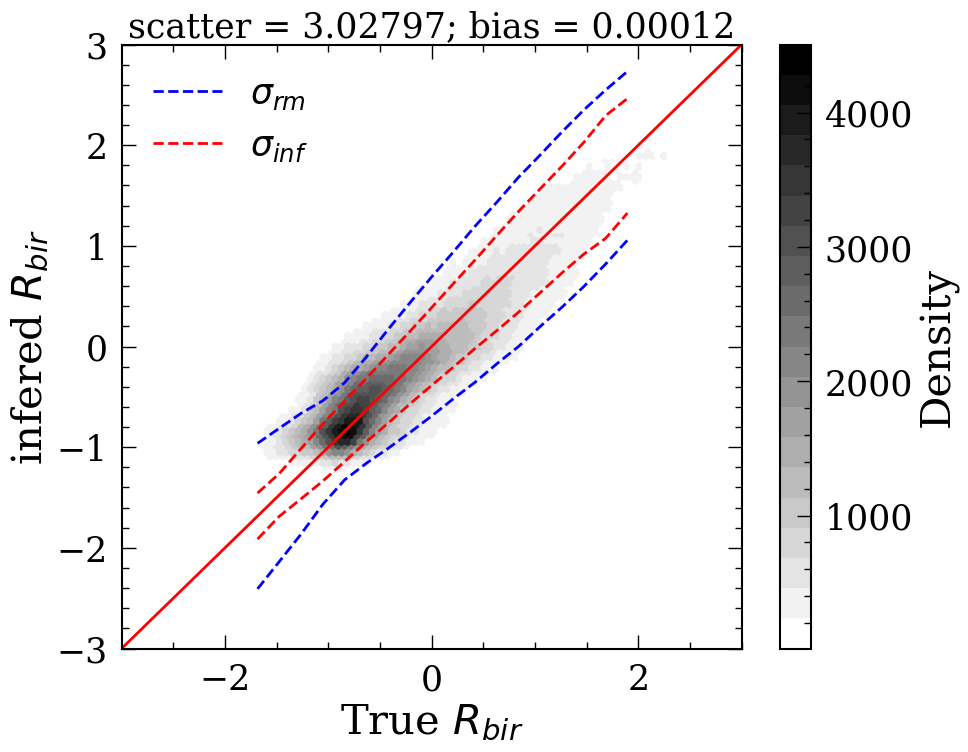

In [21]:
cmap = plt.cm.get_cmap('binary',20)
scatter, bias, diffinf = 0, 0, 0
for i in trange(len(simsnames)):
    if simsnames[i]=='1.12e12' or simsnames[i]==simNo:
        continue
    else:
        print(simsnames[i])
        
    simNo=simsnames[i]
    Rcut=True
    Rcut_thread=15
    zcut_thread=5
    
    print('Reading in simulation...')
    data = readsimdata(simNo,Rcut,Rcut_thread,zcut_thread)
    print('Finished reading in simulation...')

    y, ypred = predNew(weights, data)
    
    plt.figure(figsize=(10,8), dpi=100)
    scatter = np.std(y-ypred)+scatter
    bias  = np.mean(y-ypred)+bias
    
    plt.hexbin(y, ypred, extent=(-3,3,-3,3),gridsize=100, mincnt=10, cmap=cmap)
    Rbirs, Rstds = calcRstd(data, Rbirbin=np.linspace(-2,2,20))
    Rbirs_inf, Rstds_inf = calcRstd_inf(ypred, y, Rbirbin=np.linspace(-2,2,20))
    plt.plot(Rbirs, Rbirs+Rstds, 'b--', label = '$σ_{rm}$')
    plt.plot(Rbirs, Rbirs-Rstds, 'b--')
    plt.plot(Rbirs_inf, Rbirs_inf-Rstds_inf, 'r--', label = '$σ_{inf}$')
    plt.plot(Rbirs_inf, Rbirs_inf+Rstds_inf, 'r--')
    diffinf = diffinf+(Rstds-Rstds_inf)
    plt.plot([-3, 3], [-3, 3], "r-")
    plt.xlim(-3,3)
    plt.ylim(-3,3)
    plt.xlabel("True $R_{bir}$")
    plt.ylabel("infered $R_{bir}$")
    plt.title('scatter = %.5f; bias = %.5f'%(scatter, bias),fontsize=25)
    plt.legend()
    cb = plt.colorbar()
    cb.set_label('Density')
    plt.savefig(simsnames[i]+'_Rbirth_predW_model_disk_Rg'+simsnames[0]+'.png')
scatter = scatter/4
bias = bias/4
diffinf = np.mean(pd.Series(diffinf).dropna())/4

out755 = pd.DataFrame(np.array((np.append(allnames,['scatter','bias','scatter_pred',
                                                    'bias_pred','mean $σ_{rm}-σ_{inf}$']),
                               np.append(weights,[np.std(y-ypred),np.mean(y-ypred),scatter,bias,diffinf]), 
                               np.append(weights_err,[0, 0, 0, 0, 0]))).T,
                      columns=['names','w755','w_err755'])




In [26]:
import matplotlib
def getcolor(vrange,cm=plt.cm.get_cmap('binary')):
    cmap = cm
    norm = matplotlib.colors.Normalize(vmin=min(vrange), vmax=max(vrange))
    return [cmap(norm(i)) for i in vrange]

bulgemass = sorted(np.array(simsnames, dtype=float))
colors = getcolor(bulgemass)

outall = pd.merge(out755, out708, left_on='names', right_on='names', how='inner')
outall = pd.merge(outall, out826, left_on='names', right_on='names', how='inner')
outall = pd.merge(outall, out279, left_on='names', right_on='names', how='inner')
outall = pd.merge(outall, out696, left_on='names', right_on='names', how='inner')

for i in outall.columns:
    if i!='names':
        outall[i] = np.array(outall[i], dtype=float)
outall

names      w755  w_err755      w708  w_err708      w826  \
0                   $θ_C$ -0.000024  0.000238  0.000015  0.000126  0.000008   
1                  [Fe/H] -1.041642  0.002117 -1.621186  0.003907 -0.875820   
2                       τ -0.692874  0.002647 -1.367193  0.001098 -0.776406   
3                   $R_g$  0.361657  0.000437  0.219994  0.005000  0.267052   
4           [Fe/H]*[Fe/H] -0.053356  0.066841  0.074585  0.080053  0.022443   
5                [Fe/H]*τ  0.475069  0.038512  0.948099  0.085808  0.647095   
6            [Fe/H]*$R_g$  0.024565  0.005767  0.020183  0.009724  0.071098   
7                     τ*τ -0.279648  0.013748 -0.289767  0.030557 -0.299167   
8                 τ*$R_g$ -0.030283  0.007922  0.035635  0.014225 -0.058890   
9             $R_g$*$R_g$ -0.048646  0.002444  0.005264  0.003055  0.019562   
10                scatter  0.446997  0.000000  0.672551  0.000000  0.548541   
11                   bias  0.000024  0.000000 -0.000015  0.000000 -0.000008   
12           scatter_pred  0.756992  0.000000  0.897055  0.000000  0.787117   
13              bias_pred  0.000030  0.000000 -0.000019  0.000000 -0.000010   
14  mean $σ_{rm}-σ_{inf}$  0.428986  0.000000  0.165925  0.000000  0.327555   

    w_err826          w279  w_err279          w696  w_err696  
0   0.000126  1.379609e-07  0.000220  7.102892e-07  0.000396  
1   0.001195 -1.030792e+00  0.000251 -2.612159e+00  0.004627  
2   0.000830 -7.942301e-01  0.000174 -2.171598e+00  0.003411  
3   0.000619  1.831745e-01  0.000281  1.864663e-01  0.000479  
4   0.024155  2.453753e-02  0.000909 -6.199739e-01  0.045567  
5   0.005231  4.648497e-01  0.001227 -2.226918e-01  0.078519  
6   0.001163 -3.732038e-02  0.000185 -7.094457e-02  0.001274  
7   0.001947 -3.593227e-01  0.000392 -4.626407e-01  0.036002  
8   0.001848 -9.565044e-02  0.000296 -1.580016e-01  0.000940  
9   0.000700 -2.803409e-02  0.000121  1.583024e-02  0.000461  
10  0.000000  4.747772e-01  0.000000  1.478611e+00  0.000000  
11  0.000000 -1.379607e-07  0.000000 -7.102887e-07  0.000000  
12  0.000000  7.582340e-01  0.000000  1.606379e+00  0.000000  
13  0.000000 -1.724510e-07  0.000000 -7.102889e-07  0.000000  
14  0.000000  4.722265e-01  0.000000 -7.900343e-01  0.000000

/tmp/ipykernel_1154283/3624209679.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  outall_w['absw696'] = -abs(np.array(outall_w['w696'], dtype=float))
/tmp/ipykernel_1154283/3624209679.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  outall_s['absw696'] = -abs(np.array(outall_s['w696'], dtype=float))


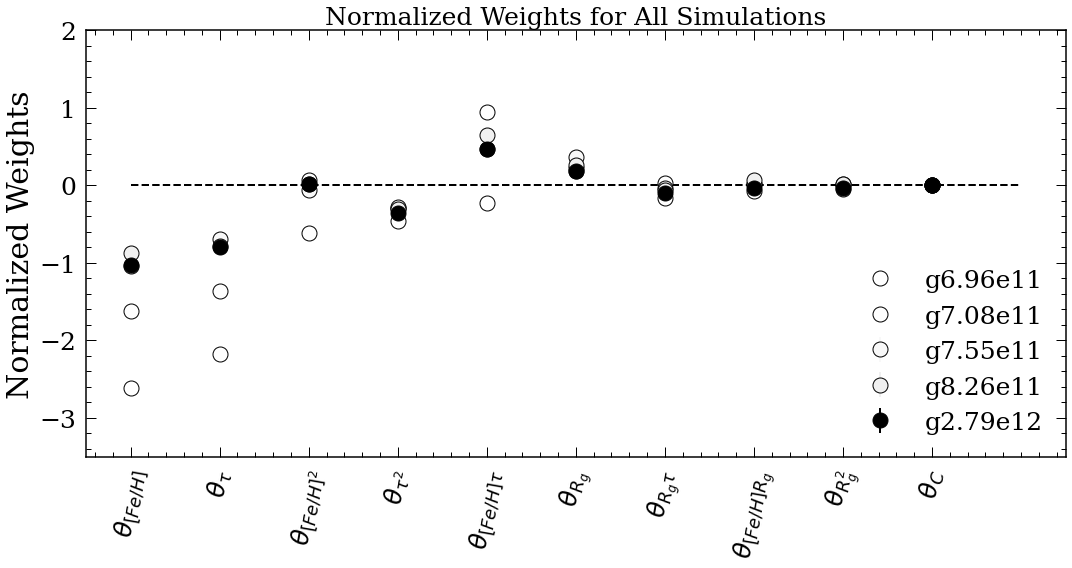

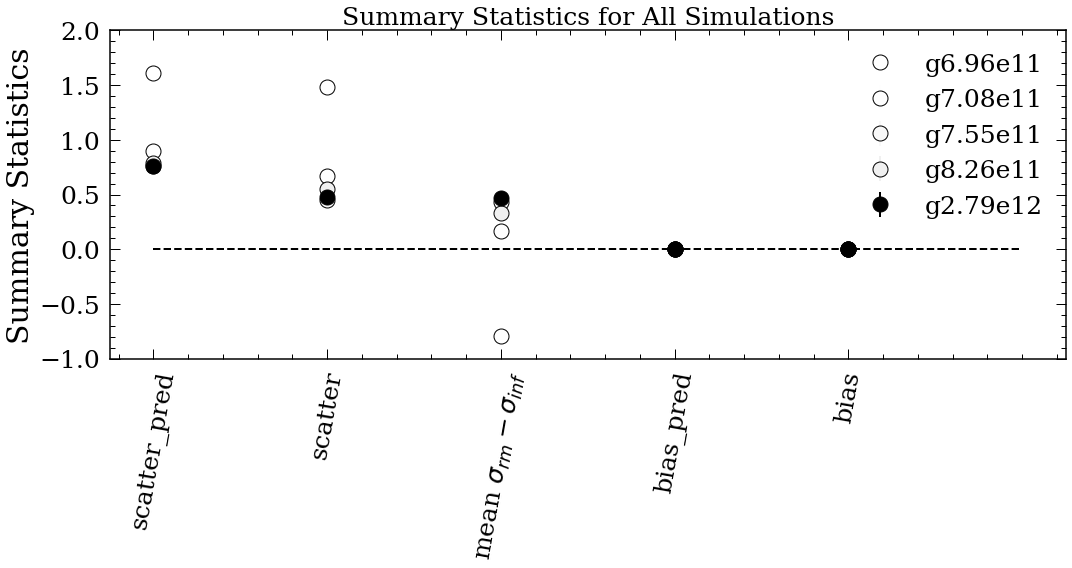

In [27]:
        
outall['names'] = ['$θ_C$', '$θ_{[Fe/H]}$','$θ_{τ}$','$θ_{R_g}$','$θ_{[Fe/H]^2}$',
                   '$θ_{[Fe/H]τ}$','$θ_{[Fe/H]R_g}$',
                   '$θ_{τ^2}$','$θ_{R_gτ}$','$θ_{R_g^2}$', 
                    'scatter','bias','scatter_pred',
                  'bias_pred','mean $σ_{rm}-σ_{inf}$']

outall_w = outall.loc[outall['names'].isin(['$θ_{[Fe/H]}$','$θ_{τ}$','$θ_{[Fe/H]τ}$',
                                            '$θ_{R_g}$','$θ_{τ^2}$','$θ_{[Fe/H]^2}$',
                                            '$θ_{R_g^2}$', '$θ_{R_gτ}$',
                                            '$θ_{[Fe/H]R_g}$','$θ_C$'])]
outall_s = outall.loc[outall['names'].isin(['scatter','bias','scatter_pred',
                                            'bias_pred','mean $σ_{rm}-σ_{inf}$'])]

outall_w['absw696'] = -abs(np.array(outall_w['w696'], dtype=float))
outall_w = outall_w.sort_values(by='absw696').reset_index(drop=True)
outall_s['absw696'] = -abs(np.array(outall_s['w696'], dtype=float))
outall_s = outall_s.sort_values(by='absw696').reset_index(drop=True)


        
plt.figure(figsize=(15,8))
plt.errorbar(range(len(outall_w)), outall_w['w696'], yerr=outall_w['w_err696'], color=colors[0],
            label='g6.96e11', fmt='o', markersize=15, markeredgecolor='k')
plt.errorbar(range(len(outall_w)), outall_w['w708'], yerr=outall_w['w_err708'], color=colors[1],
            label='g7.08e11', fmt='o', markersize=15, markeredgecolor='k')
plt.errorbar(range(len(outall_w)), outall_w['w755'], yerr=outall_w['w_err755'], color=colors[2],
            label='g7.55e11', fmt='o', markersize=15, markeredgecolor='k')
plt.errorbar(range(len(outall_w)), outall_w['w826'], yerr=outall_w['w_err826'], color=colors[3],
            label='g8.26e11', fmt='o', markersize=15, markeredgecolor='k')
plt.errorbar(range(len(outall_w)), outall_w['w279'], yerr=outall_w['w_err279'], color=colors[5],
            label='g2.79e12', fmt='o', markersize=15, markeredgecolor='k')
plt.plot([0,len(outall_w)],[0,0],'k--')
plt.ylim([-3.5,2])
plt.xticks(range(len(outall_w)), outall_w['names'], rotation=80)
plt.title('Normalized Weights for All Simulations', fontsize=25)
plt.legend(loc=4)
plt.ylabel('Normalized Weights')
plt.tight_layout()


plt.figure(figsize=(15,8))
plt.errorbar(range(len(outall_s)), outall_s['w696'], yerr=outall_s['w_err696'], color=colors[0],
            label='g6.96e11', fmt='o', markersize=15, markeredgecolor='k')
plt.errorbar(range(len(outall_s)), outall_s['w708'], yerr=outall_s['w_err708'], color=colors[1],
            label='g7.08e11', fmt='o', markersize=15, markeredgecolor='k')
plt.errorbar(range(len(outall_s)), outall_s['w755'], yerr=outall_s['w_err755'], color=colors[2],
            label='g7.55e11', fmt='o', markersize=15, markeredgecolor='k')
plt.errorbar(range(len(outall_s)), outall_s['w826'], yerr=outall_s['w_err826'], color=colors[3],
            label='g8.26e11', fmt='o', markersize=15, markeredgecolor='k')
plt.errorbar(range(len(outall_s)), outall_s['w279'], yerr=outall_s['w_err279'], color=colors[5],
            label='g2.79e12', fmt='o', markersize=15, markeredgecolor='k')
plt.plot([0,len(outall_s)],[0,0],'k--')
plt.ylim([-1,2])
plt.xticks(range(len(outall_s)), outall_s['names'], rotation=80)
plt.title('Summary Statistics for All Simulations', fontsize=25)
plt.legend(loc=1)
plt.ylabel('Summary Statistics')
plt.tight_layout()

In [29]:
outall.to_pickle('weights_disk_Rg.pkl')

In [200]:
outall

names      w755  w_err755      w708  w_err708      w826  \
0            $θ_{[Fe/H]}$ -0.000024  0.000123  0.000010  0.000093  0.000008   
1                 $θ_{τ}$ -1.041610  0.000753 -1.620701  0.002114 -0.875818   
2           $θ_{[Fe/H]τ}$ -0.692819  0.001976 -1.366982  0.000347 -0.776401   
3               $θ_{R_g}$  0.361653  0.000513  0.067094  0.064140  0.022387   
4               $θ_{τ^2}$ -0.052018  0.064095  0.220472  0.003596  0.267055   
5          $θ_{[Fe/H]^2}$  0.475874  0.037553  0.940133  0.068192 -0.299168   
6             $θ_{R_g^2}$  0.024681  0.005504  0.034305  0.011257 -0.058895   
7              $θ_{R_gτ}$ -0.279352  0.013162  0.019262  0.008184  0.071083   
8         $θ_{[Fe/H]R_g}$ -0.030113  0.007818 -0.292508  0.024407  0.647083   
9                   $θ_C$ -0.048600  0.002255  0.004980  0.002469  0.019557   
10                scatter  0.446930  0.000000  0.671046  0.000000  0.548550   
11                   bias  0.000024  0.000000 -0.000010  0.000000 -0.000008   
12           scatter_pred  0.756850  0.000000  0.896755  0.000000  0.787131   
13              bias_pred  0.000030  0.000000 -0.000013  0.000000 -0.000010   
14  mean $σ_{rm}-σ_{inf}$  0.429218  0.000000  0.166174  0.000000  0.327533   

    w_err826          w279  w_err279          w696  w_err696  
0   0.000225  1.216545e-07  0.000130  1.528777e-07  0.000426  
1   0.001556 -1.030792e+00  0.000519 -2.612134e+00  0.001562  
2   0.000679 -7.942280e-01  0.000267 -6.194393e-01  0.043117  
3   0.024381  2.457753e-02  0.001432 -2.217690e-01  0.075978  
4   0.000255  1.831703e-01  0.000331  1.864638e-01  0.000727  
5   0.002659 -9.564071e-02  0.000298 -2.171572e+00  0.001147  
6   0.002513 -3.593078e-01  0.000524 -1.580243e-01  0.001087  
7   0.001221  4.648923e-01  0.001519 -7.098583e-02  0.000422  
8   0.007417 -3.731609e-02  0.000254 -4.622103e-01  0.036208  
9   0.000595 -2.803337e-02  0.000186  1.582240e-02  0.000310  
10  0.000000  4.747828e-01  0.000000  1.478380e+00  0.000000  
11  0.000000 -1.216543e-07  0.000000 -1.528772e-07  0.000000  
12  0.000000  7.582333e-01  0.000000  1.606150e+00  0.000000  
13  0.000000 -1.520680e-07  0.000000 -1.528774e-07  0.000000  
14  0.000000  4.722282e-01  0.000000 -7.898349e-01  0.000000